# Text Mining Project - Stock Sentiment - Test Notebook

## *Predicting market behavior from tweets*

### Group 42

Carolina Pinto - 20240494 <br>
Fábio dos Santos - 20240678 <br>
Guilherme – 2024 <br>
Mariana – 2024 <br>

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
   - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Data Exploration](#4-data-exploration)
   - [4.1. Class Distribution](#41-class-distribution)
   - [4.2. Text Length](#42-text-length)
   - [4.3. Data Manipulation for Further Exploration](#43-data-manipulation-for-further-exploration)
   - [4.4. Most Frequent Words per Label](#44-most-frequent-words-per-label)
   - [4.5. Word Cloud by Label](#45-word-cloud-by-label)
- [5. Corpus Split](#5-corpus-split)
- [6. Data Preprocessing](#6-data-preprocessing)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Classification Models](#8-classification-models)
- [9. Evaluation](#9-evaluation)

# 1. Import libraries

`Step 1` Import the required libraries.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.downloader
import gensim.downloader as api
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

from keras.models import Model
from keras import layers
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Masking, LSTM, Bidirectional, Dropout, Dense, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
import torch


from transformers import AutoModel
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import StratifiedKFold

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [154]:
# pip install gensim

In [155]:
# pip install keras_preprocessing

In [156]:
SEED=42

np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Make PyTorch deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TensorFlow
tf.random.set_seed(SEED)

## Functions

In [157]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def preprocess(text_list, lemma = None, stemmer = None, word2vec=False):
    """
    Return the prepocessed text in a list "updates".

    Parameters:
    text_list : list to be preprocessed
    use_lemmatize : bool, optional
        If True, applies lemmatization to the tokens. Default is True.
    use_stemmer : bool, optional
        If True, applies stemming to the tokens. Default is False.
    """

    stop_words = set(stopwords.words('english'))

    updates = []

    for j in text_list:

        text = j

        # Lower case text
        text = text.lower()


        # Remove emojis
        text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

        # Remove unknown character �
        text = text.replace("�", "")

        # Remove Regular Unwanted Expressions
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)

        # Remove Punctuation
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        #Remove Stopwords
        tokens = [word for word in tokens if word not in stop_words]

        #Lemmatize
        if lemma:
            tokens = [lemma.lemmatize(word) for word in tokens]

        #Stemming
        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

        # Rejoin tokens

        if word2vec:
            cleaned_text=tokens
        else:
            cleaned_text = " ".join(tokens)

        updates.append(cleaned_text)

    return updates

In [158]:
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [159]:
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # List of all words/vocabulary in the model
    word_vec = w2v.get_vector           # Creates a short cut that retrieves the embedding method for a given word
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

In [160]:
def generate_embeddings(
    texts,
    embeddings_model,
    for_sequence_model=False,
    desc="Generating Embeddings"
):
    """
    Generates either CLS embeddings (1 per text) or full token embeddings (sequence) for each input text.

    Args:
        texts (list of str): List of input texts.
        embeddings_model (callable): Hugging Face pipeline("feature-extraction", ...).
        use_cls (bool): If True, use the CLS token embedding; if False, use mean pooling.
        for_sequence_model (bool): If True, return full token-level embeddings (for RNNs).
        desc (str): tqdm progress bar description.

    Returns:
        If for_sequence_model:
            List[torch.Tensor]: Each tensor is [seq_len, hidden_dim].
        Else:
            torch.Tensor: Tensor of shape [num_texts, hidden_dim].
    """
    processed = []

    for text in tqdm(texts, desc=desc):
        output = embeddings_model(text)  # list[list[list]]
        token_embeddings = output[0]  # get token vectors from the first (and only) item in batch
        token_embeddings = torch.tensor(token_embeddings)  # shape: [seq_len, hidden_dim]

        if for_sequence_model:
            processed.append(token_embeddings)  # shape: [seq_len, hidden_dim]
        else:
            summary_vector = token_embeddings[0]  # [CLS] token embedding
            processed.append(summary_vector)

    if for_sequence_model:
        return processed
    else:
        return torch.stack(processed)  # shape: [num_texts, hidden_dim]


In [161]:
feateng_list=['BOW', 'Word2Vec', 'Glove', 'RobertaBase', 'XLMRoberta', 'Finbert', 'DistilbertCased']

glove_model_100 = gensim.downloader.load(f'glove-twitter-{100}')
def apply_feateng(X_tr, X_te, y_tr, y_te, feateng, model_name):
    if feateng=='BOW':
        X_tr_cleaned = preprocess(X_tr['text'], lemma=lemma)
        X_te_cleaned = preprocess(X_te['text'])
        bow = CountVectorizer(binary=True)
        X_train_bow = bow.fit_transform(X_tr_cleaned)
        X_val_bow = bow.transform(X_te_cleaned)
        return X_train_bow, X_val_bow, y_tr, y_te

    elif feateng=='Word2Vec':
        X_tr_word2vec = preprocess(X_tr['text'], word2vec=True)
        X_tr_cleaned = preprocess(X_tr['text'])
        X_te_cleaned = preprocess(X_te['text'])
        w2v_model_100 = Word2Vec(sentences=X_tr_word2vec, vector_size=100, window=5, min_count=1, workers=4, sg=1)
        if model_name in ['KNN', 'LogReg']:
            X_train_avgembeddings = np.array([average_embedding(text, w2v_model_100.wv, dim=100) for text in X_tr_cleaned])
            X_val_avgembeddings = np.array([average_embedding(text, w2v_model_100.wv, dim=100) for text in X_te_cleaned])
            return X_train_avgembeddings, X_val_avgembeddings, y_tr, y_te
        else:
            X_train_embeddings = corpus2vec(X_tr_cleaned, w2v_model_100.wv)
            X_val_embeddings = corpus2vec(X_te_cleaned, w2v_model_100.wv)
            train_len = []
            for i in X_train_embeddings:
                train_len.append(len(i))
            X_train_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_embeddings, padding="post", dtype='float64')
            X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_embeddings, padding="post", dtype='float64')
            y_tr_encoded = tf.one_hot(y_tr, depth=3)
            y_te_encoded = tf.one_hot(y_te, depth=3)
            return X_train_pad, X_val_pad, y_tr_encoded, y_te_encoded

    elif feateng=='Glove':
        X_tr_cleaned=preprocess(X_tr['text'], lemma=lemma)
        X_te_cleaned=preprocess(X_te['text'], lemma=lemma)
        if model_name in ['KNN', 'LogReg']:
            X_train_avgembeddings = np.array([average_embedding(text, glove_model_100, dim=100) for text in X_tr_cleaned])
            X_val_avgembeddings = np.array([average_embedding(text, glove_model_100, dim=100) for text in X_te_cleaned])
            return X_train_avgembeddings, X_val_avgembeddings, y_tr, y_te
        else:
            X_train_embeddings = corpus2vec(X_tr_cleaned, glove_model_100)
            X_val_embeddings = corpus2vec(X_te_cleaned, glove_model_100)
            train_len = []
            for i in X_train_embeddings:
                train_len.append(len(i))
            X_train_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_embeddings, padding="post", dtype='float64')
            X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_embeddings, padding="post", dtype='float64')
            y_tr_encoded = tf.one_hot(y_tr, depth=3)
            y_te_encoded = tf.one_hot(y_te, depth=3)
            return X_train_pad, X_val_pad, y_tr_encoded, y_te_encoded


    elif feateng in ['RobertaBase', 'XLMRoberta', 'Finbert', 'DistilbertCased']:
        X_tr_cleaned=preprocess(X_tr['text'])
        X_te_cleaned=preprocess(X_te['text'])
        if feateng=='RobertaBase':
            MODEL="cardiffnlp/twitter-roberta-base-sentiment"
        elif feateng=='XLMROberta':
            MODEL="cardiffnlp/twitter-xlm-roberta-base-sentiment"
        elif feateng=='Finbert':
            MODEL="ProsusAI/finbert"
        elif feateng=='DistilbertCased':
            MODEL="distilbert-base-cased"
        model = pipeline("feature-extraction", model=MODEL, tokenizer=MODEL, batch_size=16, truncation=True)
        if model_name in ['KNN', 'LogReg']:
            X_train_avgembeddings=generate_embeddings(X_tr_cleaned, model)
            X_val_avgembeddings=generate_embeddings(X_te_cleaned, model)
            return X_train_avgembeddings, X_val_avgembeddings, y_tr, y_te

        else:
            X_train_embeddings=generate_embeddings(X_tr_cleaned, model, for_sequence_model=True)
            X_val_embeddings=generate_embeddings(X_te_cleaned, model, for_sequence_model=True)
            train_len = []
            for i in X_train_embeddings:
                train_len.append(len(i))
            X_train_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_embeddings, padding="post", dtype='float64')
            X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_embeddings, padding="post", dtype='float64')
            y_tr_encoded = tf.one_hot(y_tr, depth=3)
            y_te_encoded = tf.one_hot(y_te, depth=3)
            return X_train_pad, X_val_pad, y_tr_encoded, y_te_encoded

In [189]:
def obtain_predictions(X_tr, X_te, y_tr, y_te_encoded, model_name):
    # y_te_encoded only needed for LSTM
    if model_name == 'KNN':
        # Obtain model
        knn_args = {"n_neighbors": 5, "metric": "cosine", "weights": "uniform"} #determined previously
        model = KNeighborsClassifier(**knn_args)

        # Obtain preds
        model.fit(X_tr, y_tr)
        y_tr_pred = model.predict(X_tr)
        y_te_pred = model.predict(X_te)

    elif model_name == 'LogReg':
        # Obtain model
        logreg_args = {"max_iter": 1000, "solver": "lbfgs"}
        model = LogisticRegression(**logreg_args)

        # Obtain preds
        model.fit(X_tr, y_tr)
        y_tr_pred = model.predict(X_tr)
        y_te_pred = model.predict(X_te)
    
    elif model_name == 'LSTM':
        # Obtain model
        train_len=len(X_tr[0])
        embedding_dim = len(X_tr[0][0])
        input_ = Input(shape=(train_len, embedding_dim))
        mask = Masking(mask_value=0)(input_)

        # Bi-LSTM now returns just the final output vector [B, 2*units]
        lstm_out = Bidirectional(LSTM(units=32, return_sequences=False))(mask)

        bn = BatchNormalization()(lstm_out)
        drop = Dropout(0.4)(bn)
        act  = Dense(3,
                    activation='softmax',
                    kernel_regularizer=regularizers.l2(1e-4)
                    )(drop)

        model = Model(input_, act)
        model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=[CategoricalAccuracy(name="accuracy"), F1Score(average="macro", name="f1_score")])

        # Obtain preds
        model.fit(
            X_tr, y_tr, #X_tr already comes padded, y_tr already comes encoded
            validation_data=(X_te, y_te_encoded),
            batch_size=16,
            epochs=40,
            verbose=1
        )
        y_tr_pred_enc = model.predict(X_tr) 
        y_tr_pred = []
        for prediction in y_tr_pred_enc:
            y_tr_pred.append(np.argmax(prediction, axis=None, out=None))
        # y_tr_pred is now obtained (in the categorical format)
        y_te_pred_enc = model.predict(X_te)
        y_te_pred = []
        for prediction in y_te_pred_enc:
            y_te_pred.append(np.argmax(prediction, axis=None, out=None))
        # y_te_pred is now obtained (in the categorical format)

    return y_tr_pred, y_te_pred


In [190]:
from sklearn.model_selection import StratifiedKFold

def feateng_crossval(
    X,                            # original DataFrame
    y,                            # original labels Series
    feateng_list,                 # e.g. ['BOW','Word2Vec',…,'RobertaBase',…]
    model_name,                   # 'KNN'|'LogReg'|'LSTM'
    precomputed_cls,              # dict[name->(N,H) array]
    precomputed_seq,              # dict[name->list of N (Lᵢ,H) arrays]
    cv=9,
    seed=SEED
):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    results = []
    for feateng in feateng_list:
        for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), 1):
            # ─── pick the right precomputed embeddings ───
            y_tr_labels = y.iloc[tr_idx]
            y_te_labels = y.iloc[te_idx]
            if feateng in precomputed_cls and model_name in ['KNN','LogReg']:
                X_tr = precomputed_cls[feateng][tr_idx]
                X_te = precomputed_cls[feateng][te_idx]
                y_for_pred_tr, y_for_pred_te = y_tr_labels, y_te_labels

            elif feateng in precomputed_seq and model_name == 'LSTM':
                seq_all = precomputed_seq[feateng]
                seq_tr = [seq_all[i] for i in tr_idx]
                seq_te = [seq_all[i] for i in te_idx]
                # pad to the max length in this fold:
                max_len = max(len(s) for s in seq_tr)
                X_tr = tf.keras.preprocessing.sequence.pad_sequences(
                    seq_tr, maxlen=max_len, padding='post', dtype='float32')
                X_te = tf.keras.preprocessing.sequence.pad_sequences(
                    seq_te, maxlen=max_len, padding='post', dtype='float32')
                y_tr_encoded = tf.one_hot(y.iloc[tr_idx], depth=3)
                y_te_encoded = tf.one_hot(y.iloc[te_idx], depth=3)
                y_for_pred_tr, y_for_pred_te = y_tr_encoded, y_te_encoded


            else:
                # fallback for BOW / Word2Vec / Glove
                X_tr, X_te, y_for_pred_tr, y_for_pred_te = apply_feateng(
                    X.iloc[tr_idx], X.iloc[te_idx],
                    y.iloc[tr_idx], y.iloc[te_idx],
                    feateng, model_name
                )

            # ─── fit & predict ───
            y_tr_pred, y_te_pred = obtain_predictions(
                X_tr, X_te, y_for_pred_tr, y_for_pred_te, model_name
            )

            # Calculate metrics
            train_f1 = f1_score(y_tr_labels, y_tr_pred, average='macro')
            test_f1 = f1_score(y_te_labels, y_te_pred, average='macro')
            train_acc = accuracy_score(y_tr_labels, y_tr_pred)
            test_acc = accuracy_score(y_te_labels, y_te_pred)
            results.append({
                'model': model_name,
                'feateng': feateng,
                'fold': fold,
                'train_f1': train_f1,
                'test_f1': test_f1,
                'train_acc': train_acc,
                'test_acc': test_acc
            })

    return pd.DataFrame(results)


In [191]:
def plot_f1_by_feateng(df, model_name):
    """
    Creates grouped boxplots for train and test F1 scores by feature engineering method,
    with train in blue and test in red, and y-axis fixed between 0.5 and 0.9.
    
    Parameters:
    - df: DataFrame containing columns ['model', 'feateng', 'train_f1', 'test_f1']
    - model_name: string specifying which model to plot
    """
    # Filter for the chosen model
    df_model = df[df['model'] == model_name]
    featengs = df_model['feateng'].unique()
    
    data = []
    positions = []
    
    # Gather data and positions
    for i, feat in enumerate(featengs):
        train_vals = df_model[df_model['feateng'] == feat]['train_f1'].values
        test_vals = df_model[df_model['feateng'] == feat]['test_f1'].values
        
        pos_base = i * 2
        positions.extend([pos_base, pos_base + 0.4])
        data.extend([train_vals, test_vals])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    box = ax.boxplot(
        data,
        positions=positions,
        widths=0.35,
        patch_artist=True,
        medianprops={'color': 'black'}
    )
    
    # Color boxes
    for idx, patch in enumerate(box['boxes']):
        color = 'blue' if idx % 2 == 0 else 'red'
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
    
    # Configure axes
    xticks = [i * 2 + 0.2 for i in range(len(featengs))]
    ax.set_xticks(xticks)
    ax.set_xticklabels(featengs)
    ax.set_xlabel('Feature Engineering Method')
    ax.set_ylabel('Macro F1 Score')
    ax.set_title(f'Macro F1 by Feature Engineering for {model_name}')
    ax.set_ylim(0.5, 1)
    
    # Legend
    import matplotlib.patches as mpatches
    train_patch = mpatches.Patch(color='blue', label='train_f1')
    test_patch = mpatches.Patch(color='red', label='test_f1')
    ax.legend(handles=[train_patch, test_patch])
    
    plt.tight_layout()
    plt.show()


In [166]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_test_f1_by_model(df):
    """
    Creates grouped boxplots of test_f1 scores for each model, grouped by feature engineering method.
    
    Parameters:
    - df: DataFrame containing columns ['model', 'feateng', 'test_f1']
    
    Returns:
    - fig, ax: Matplotlib Figure and Axes objects.
    """
    # Get unique feature engineering methods and models
    featengs = df['feateng'].unique()
    models = df['model'].unique()
    n_models = len(models)
    
    offset = 0.4
    group_stride = (n_models + 1) * offset  # space reserved per feature group

    # Prepare data, positions, and colors
    data = []
    positions = []
    colors = []
    
    cmap = plt.get_cmap('tab10')
    
    for i, feat in enumerate(featengs):
        for j, model in enumerate(models):
            vals = df[(df['feateng'] == feat) & (df['model'] == model)]['test_f1'].values
            pos = i * (n_models + 1) + j
            data.append(vals)
            positions.append(pos)
            colors.append(cmap(j))
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bplots = ax.boxplot(
        data,
        positions=positions,
        widths=0.35,
        patch_artist=True,
        medianprops={'color': 'black'}      # <-- Add this
    )
    
    # Color each box
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)
    
    # X-axis ticks
    centers = [i * group_stride + (n_models - 1) * offset / 2 for i in range(len(featengs))]
    ax.set_xticks(centers)
    ax.set_xticklabels(featengs)
    ax.set_xlabel('Feature Engineering Method')
    ax.set_ylabel('Test Macro F1 Score')
    ax.set_title('Test Macro F1 by Model and Feature Engineering')
    ax.set_ylim(0.5, 1)
    
    # Legend
    legend_patches = [mpatches.Patch(color=cmap(idx), label=model) for idx, model in enumerate(models)]
    ax.legend(handles=legend_patches, title='Model')
    
    plt.tight_layout()
    plt.show()


In [167]:
from sklearn.metrics import classification_report

def make_metrics_dict(y_true, y_pred):
    rpt = classification_report(
        y_true,
        y_pred,
        output_dict=True,
        zero_division=0
    )
    # Only keep class ’0’, ’1’, ’2’ and the ’macro avg’; drop ’weighted avg’ and support counts
    keys_to_keep = ['0', '1', '2', 'macro avg']
    flat = {}
    for label in keys_to_keep:
        met = rpt[label]
        for m_name in ['precision', 'recall', 'f1-score']:
            key = f"{label.replace(' ', '')}{m_name}"
            flat[key] = met[m_name]
    return flat


def make_metrics_dict_transformers(data_loader, model, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    rpt=classification_report(all_labels, all_preds, target_names=["0", "1", "2"],output_dict=True, zero_division=0, digits=4)

    keys_to_keep = ["0", "1", "2", "macro avg"]
    flat = {}
    for label in keys_to_keep:
        met = rpt[label]
        for m_name in ['precision', 'recall', 'f1-score']:
            key = f"{label.replace(' ', '')}{m_name}"
            flat[key] = met[m_name]
    return flat

# 1.1. Google Colab Setup

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

Sat Jun 14 14:35:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             13W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

# 2. Data Integration

`Step 2` Import the dataset __train.csv__ using the method **read_csv()** from pandas.

In [168]:
df = pd.read_csv('../Project_Data/train.csv')

## 2.1. Data Description

`text`: tweets content. <br>
`label`: sentimental label, it can be bearish (0), bullish (1) or neutral (2).

# 3. Data Content

`Step 3` Check the first 5 rows of the dataset.

In [13]:
df.head(20)

text  label
0   $BYND - JPMorgan reels in expectations on Beyo...      0
1   $CCL $RCL - Nomura points to bookings weakness...      0
2   $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3   $ESS: BTIG Research cuts to Neutral https://t....      0
4   $FNKO - Funko slides after Piper Jaffray PT cu...      0
5   $FTI - TechnipFMC downgraded at Berenberg but ...      0
6       $GM - GM loses a bull https://t.co/tdUfG5HbXy      0
7   $GM: Deutsche Bank cuts to Hold https://t.co/7...      0
8                  $GTT: Cowen cuts to Market Perform      0
9   $HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...      0
10  $HOG - Moody's warns on Harley-Davidson https:...      0
11  $HXL - Citing aero ties, Wells slashes PT on H...      0
12  $I - Intelsat cut to Market Perform at Raymond...      0
13  $KRG: Compass Point cuts to Sell https://t.co/...      0
14  $LK - Muddy Waters goes short Luckin Coffee ht...      0
15  $MANT - ManTech downgraded ahead of difficult ...      0
16                 $MDCO: Oppenheimer cuts to Perform      0
17  $MPLX $MPC - MPLX cut at Credit Suisse on pote...      0
18  $MSGN - Imperial downgrades MSG Networks amid ...      0
19  $MTLS - Piper hits the Materialise sidelines h...      0

`Step 4` Check the number of rows and columns of the data frame.

In [14]:
df.shape

(9543, 2)

`Step 5` Check the features data types and info.

In [15]:
df.dtypes

text     object
label     int64
dtype: object

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Conclusions
- Our data is composed of **9543** observations and **2** columns. <br>
- Variable text is object and variable label is an integer as expected. <br>
- There are no null values in the observations. <br>
- Our tweets have a lot of "noise" letters and symbols like hashtags, dollar signs, links, punctuation and numbers. This should be adressed later on.

# 4. Data Exploration

`Step 6` Defining the colors to use in our visualizations for consistent representation (NOVA IMS official colors).

In [17]:
color_390 = (190/255, 214/255, 47/255)  # Pantone 390 C
color_431 = (92/255, 102/255, 108/255)  # Pantone 431 C

## 4.1. Class Distribution

`Step 7` Check Class Distribution (plot and percentage).

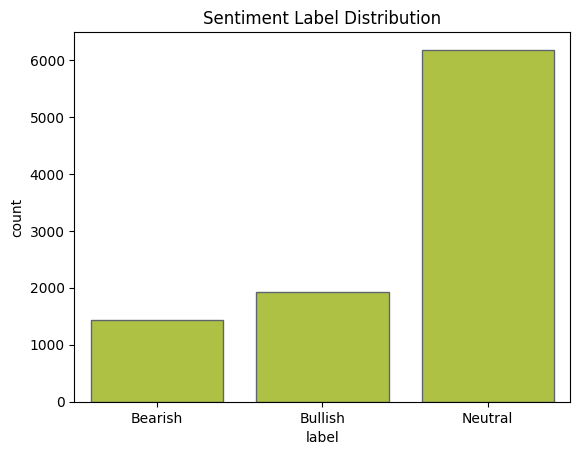

label
2    64.738552
1    20.150896
0    15.110552
Name: proportion, dtype: float64


In [18]:
sns.countplot(data=df, x='label', color=color_390, edgecolor=color_431)
plt.title("Sentiment Label Distribution")
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.show()

print(df['label'].value_counts(normalize=True) * 100)

- We can see that our labels are unbalanced, more than 60% is classified as "Neutral", 20% as "Bullish" and 15% as "Bearish".

## 4.2. Text Length

`Step 8` Check Text Length of the tweets per label.

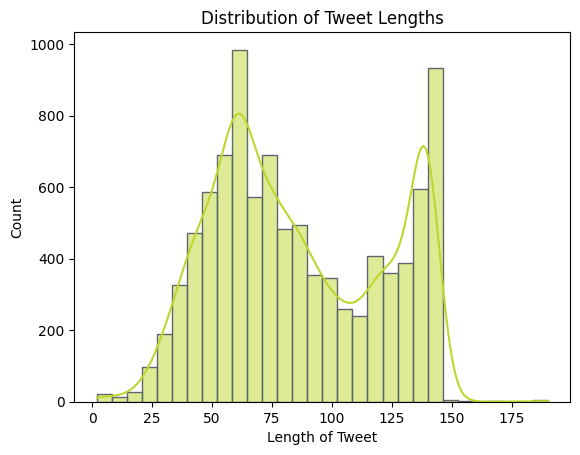

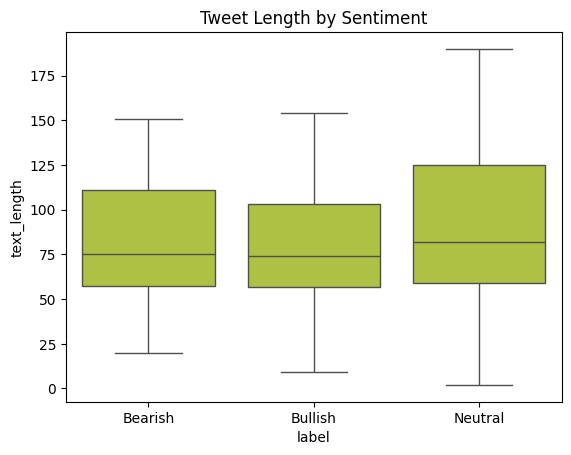

In [19]:
df['text_length'] = df['text'].apply(len)

sns.histplot(df['text_length'], bins=30, kde=True, color=color_390, edgecolor=color_431)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet")
plt.show()

# Grouped by label
sns.boxplot(data=df, x='label', y='text_length', color=color_390)
plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
plt.title("Tweet Length by Sentiment")
plt.show()

- The different labels have a simillar distribution in terms of tweet length. <br>
- The tweets length are distributed in a normal distribution with two peaks at length between 60-65 and 140-145. <br>
- There are a lot of tweets (approximately 1000) with length between 60-65, and around 900 with length between 140-145. This represents approximately 19% of the data.

## 4.3. Data Manipulation for Further Exploration

- We want to check the most frequent words per label and the word clouds for each label. At this point our data is raw and we wouldn't get significant analysis. <br>
- For that reason in this section we will copy our dataset in order to do a small preprocessing (tokenize) and then perform the desired analysis. <br>
- After this data manipulation and the referred two analysis we will continue our work with corpus split and data preprocessing from the original dataset.

`Step 9` Using a copy of our dataset we tokenize the tweets in order to have a more accurate analysis.

In [20]:
df_copy = deepcopy(df)

stop_words = set(stopwords.words('english'))

# Preprocessing: basic cleaning and tokenization
def clean_and_tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

df_copy['tokens'] = df_copy['text'].apply(clean_and_tokenize)

df_copy

text  label  text_length  \
0     $BYND - JPMorgan reels in expectations on Beyo...      0           77   
1     $CCL $RCL - Nomura points to bookings weakness...      0          102   
2     $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0           94   
3     $ESS: BTIG Research cuts to Neutral https://t....      0           59   
4     $FNKO - Funko slides after Piper Jaffray PT cu...      0           71   
...                                                 ...    ...          ...   
9538  The Week's Gainers and Losers on the Stoxx Eur...      2          136   
9539  Tupperware Brands among consumer gainers; Unil...      2           67   
9540  vTv Therapeutics leads healthcare gainers; Myo...      2           89   
9541    WORK, XPO, PYX and AMKR among after hour movers      2           47   
9542             YNDX, I, QD and OESX among tech movers      2           38   

                                                 tokens  
0     [bynd, jpmorgan, reels, expectations, beyond, ...  
1     [ccl, rcl, nomura, points, bookings, weakness,...  
2     [cx, cemex, cut, credit, suisse, jp, morgan, w...  
3                  [ess, btig, research, cuts, neutral]  
4        [fnko, funko, slides, piper, jaffray, pt, cut]  
...                                                 ...  
9538  [weeks, gainers, losers, stoxx, europe, dec, e...  
9539  [tupperware, brands, among, consumer, gainers,...  
9540  [vtv, therapeutics, leads, healthcare, gainers...  
9541        [work, xpo, pyx, amkr, among, hour, movers]  
9542              [yndx, qd, oesx, among, tech, movers]  

[9543 rows x 4 columns]

## 4.4. Most Frequent Words per Label

`Step 10` Check top 10 most frequent words per label.


Top 10 words for Bearish tweets:
stock: 148
us: 99
misses: 85
coronavirus: 79
oil: 78
economy: 68
market: 66
stocks: 64
price: 64
china: 63


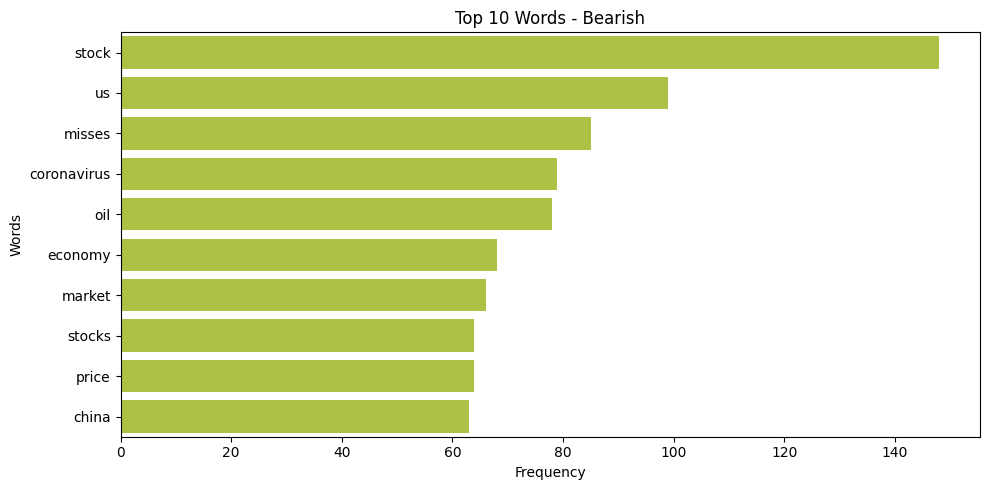


Top 10 words for Bullish tweets:
stock: 255
beats: 164
price: 137
us: 120
target: 117
stocks: 114
shares: 112
revenue: 106
market: 101
new: 97


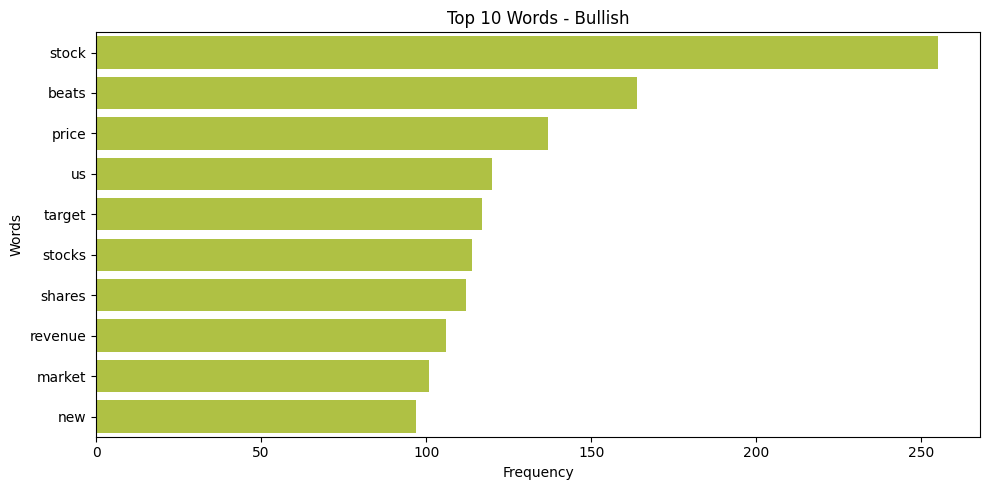


Top 10 words for Neutral tweets:
stock: 570
marketscreener: 376
results: 315
new: 285
earnings: 256
us: 233
says: 233
dividend: 225
reports: 222
inc: 195


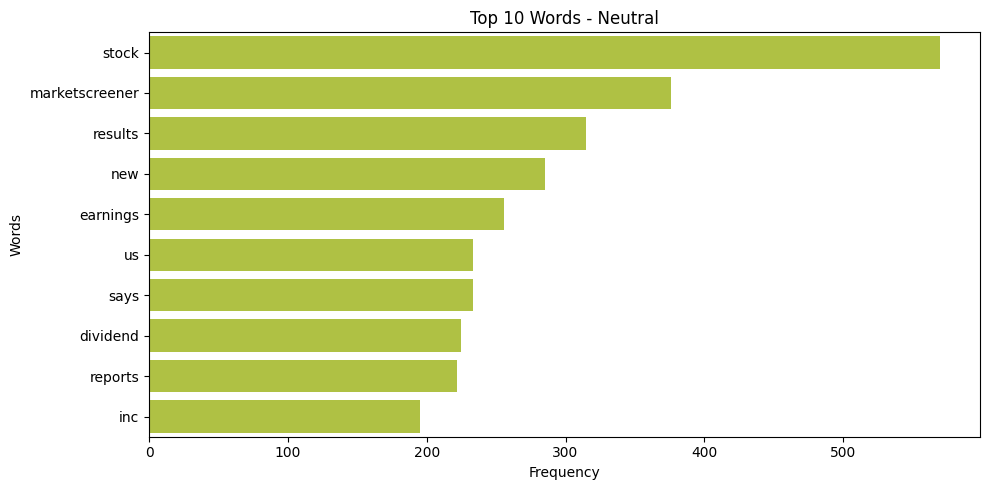

In [21]:
# Map labels to names
label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Show top 10 words per label
def get_top_words(df, label, top_n=10):
    all_words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
    most_common = Counter(all_words).most_common(top_n)

    print(f"\nTop {top_n} words for {label_names[label]} tweets:")
    for word, count in most_common:
        print(f"{word}: {count}")

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), color=color_390)
    plt.title(f"Top {top_n} Words - {label_names[label]}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()

# Loop through each label
for label in sorted(df_copy['label'].unique()):
    get_top_words(df_copy, label, top_n=10)

In [22]:
df_copy.text_length.describe()

count    9543.000000
mean       85.858325
std        35.138568
min         2.000000
25%        58.000000
50%        79.000000
75%       120.000000
max       190.000000
Name: text_length, dtype: float64

- All three labels have the same most common word as "stock" but also a good amount of the plural "stocks". <br>
- "us" also have a good representation in all the 3 labels. <br>
- Even though there is a significance difference between labels there are still some common words between them. <br>
- Neutral tweets don't have such a big gap between the top 5 most common words, which makes the words distribution more balanced. <br>
- The largest tweet have 190 words while the smallest one have 2. <br>
- In average the tweets have around 79 words.

## 4.5. Word Cloud by Label

`Step 11` Check Word Cloud of the different labels.

Word cloud for Bearish label:


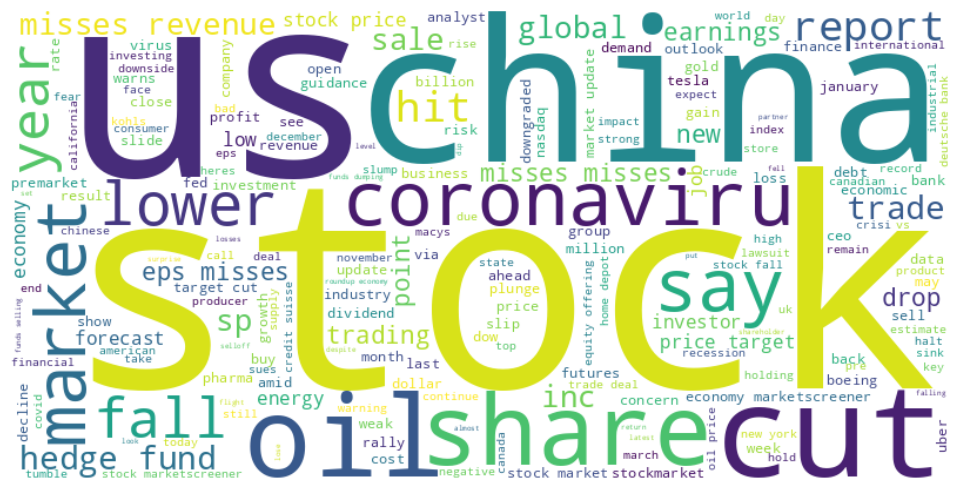

Word cloud for Bullish label:


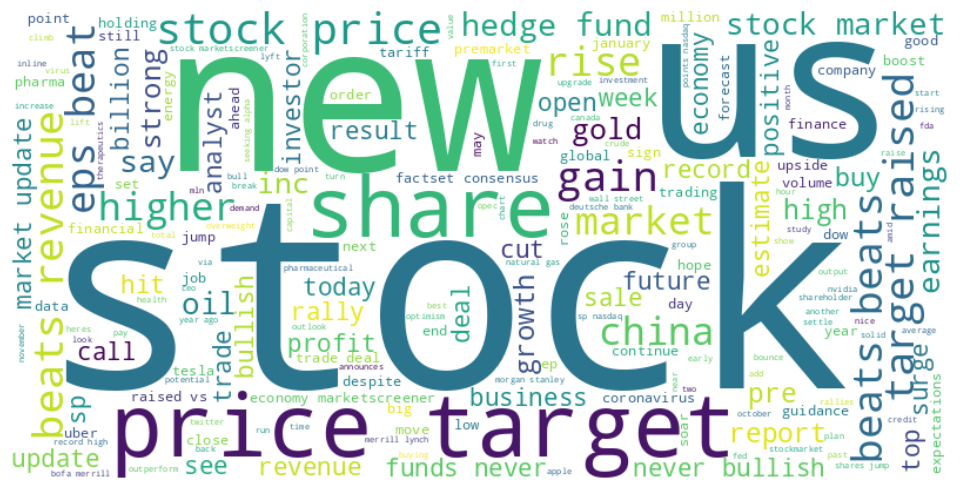

Word cloud for Neutral label:


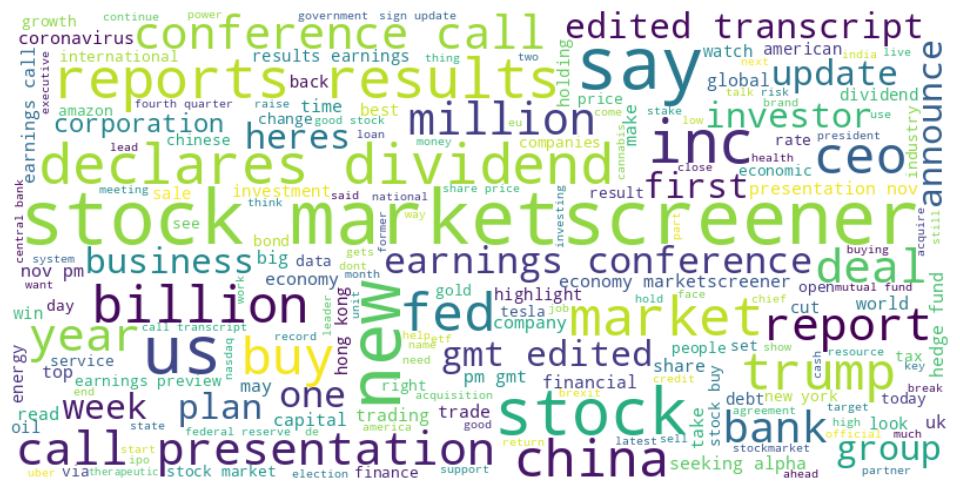

In [23]:
def plot_wordcloud(df, label, label_names):
    # Combine all tokens into one string
    text = " ".join(df[df['label'] == label]['tokens'].sum())

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='viridis').generate(text)

    print(f"Word cloud for {label_names[label]} label:")

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate word clouds for each label
for label in sorted(df_copy['label'].unique()):
    plot_wordcloud(df_copy, label, label_names)

- As previously observed, “stock” appears as the most prominent word across all sentiment labels. However, in the Neutral label, it stands out less clearly due to a more even distribution among the top words. <br>
- Overall, the Neutral label exhibits a more balanced word frequency distribution compared to the Bearish and Bullish labels. This aligns with expectations: neutral tweets typically lack strong sentiment indicators, resulting in fewer dominant or sentiment-specific keywords that clearly classify the text as bullish or bearish.

# 5. Corpus Split

Since our corpus have less than 10000 rows we will split it in train, validation and test in a 80%/10%/10% split.

`Step 12` Create a copy of the original dataframe named **data**.

In [169]:
data = deepcopy(df)
data

text  label
0     $BYND - JPMorgan reels in expectations on Beyo...      0
1     $CCL $RCL - Nomura points to bookings weakness...      0
2     $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3     $ESS: BTIG Research cuts to Neutral https://t....      0
4     $FNKO - Funko slides after Piper Jaffray PT cu...      0
...                                                 ...    ...
9538  The Week's Gainers and Losers on the Stoxx Eur...      2
9539  Tupperware Brands among consumer gainers; Unil...      2
9540  vTv Therapeutics leads healthcare gainers; Myo...      2
9541    WORK, XPO, PYX and AMKR among after hour movers      2
9542             YNDX, I, QD and OESX among tech movers      2

[9543 rows x 2 columns]

__`Step 13`__ Create a varaible called `X` that store the values of the input features and `y` that stores the values of the target feature.

In [170]:
X = data.drop(columns=['label'], axis =1)
y = data['label']

__`Step 14`__ Split the data in train and validation set in a 80/20 split, with random_state = 42, stratification by y and with shuffle of the dataset.

In [171]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=SEED,
                                                    stratify=y,
                                                    shuffle=True
                                                    )

In [172]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    test_size=1/9,
                                                    random_state=SEED,
                                                    stratify=y_train_val,
                                                    shuffle=True
                                                    )

This first split was made for testing the preprocessing methods and the models. Model and feature engeeniring accessment we will use cross validation with the preprocessing inside.

# 6. Data Preprocessing

<span style="color:red">
PARA OPTIMIZAR O MODELO: </span> <br>
- Procurar diferentes lemmatizers e stemmers e testa-los em gridsearch para ver qual o melhor modelo <br>
- Procurar outras formas de preprocessing (corrigir typos, etc etc)<br>
- Temos de aplicar o preprocessement ao test?


__`Step 15`__ Create a function to do the data preprocessing. It includes:<br>
|Preprocessement                                  |
|------------------------------------|
| Lowercasing |
| Removes Regular Unwanted Expressions   |
| Remove Punctuation           |
| Tokenization |
| Remove Stop Words                    |
| Lemmatization |
| Stemming                    |

In [76]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def preprocess(text_list, lemma = None, stemmer = None, word2vec=False):
    """
    Return the prepocessed text in a list "updates".

    Parameters:
    text_list : list to be preprocessed
    use_lemmatize : bool, optional
        If True, applies lemmatization to the tokens. Default is True.
    use_stemmer : bool, optional
        If True, applies stemming to the tokens. Default is False.
    """

    stop_words = set(stopwords.words('english'))

    updates = []

    for j in tqdm(text_list):

        text = j

        # Lower case text
        text = text.lower()

        # Remove Regular Unwanted Expressions
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)

        # Remove Punctuation
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        #Remove Stopwords
        tokens = [word for word in tokens if word not in stop_words]

        #Lemmatize
        if lemma:
            tokens = [lemma.lemmatize(word) for word in tokens]

        #Stemming
        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

        # Rejoin tokens

        if word2vec:
            cleaned_text=tokens
        else:
            cleaned_text = " ".join(tokens)

        updates.append(cleaned_text)

    return updates

__`Step 16`__ Apply the preprocessement to X_train and X_val.

In [77]:
X_train['tokens'] = preprocess(X_train['text'])
X_train

100%|██████████| 7633/7633 [00:00<00:00, 18668.37it/s]


text  \
447   Brazil's central bank stepped in to prop up th...   
5073  Singapore Frees Listed Local Developers From H...   
5941  $RPAY - Repay Holdings buys Ventanex for up to...   
5479  WHO Pushes Countries to Share More Patient Det...   
4654  How clean hydrogen could make the steel indust...   
...                                                 ...   
6226  JPMorgan anticipates ‘disorderly’ year-end fun...   
9186  $IMMU (+3.2% pre) FDA GRANTS FAST TRACK DESIGN...   
3590  Hero MotoCorp Q3 Results: Profit Beats Estimat...   
1261  Applied DNA Announces Issuance of U.S. Patent ...   
5407  Warren’s Wealth Tax Would Raise Up to $2.7 Tri...   

                                                 tokens  
447          brazils central bank stepped prop currency  
5073  singapore frees listed local developers homesa...  
5941                  rpay repay holdings buys ventanex  
5479  pushes countries share patient details combat ...  
4654  clean hydrogen could make steel industry less ...  
...                                                 ...  
6226  jpmorgan anticipates ‘ disorderly ’ yearend fu...  
9186  immu pre fda grants fast track designation sac...  
3590  hero motocorp q results profit beats estimates...  
1261  applied dna announces issuance us patent prote...  
5407  warren ’ wealth tax would raise trillion years...  

[7633 rows x 2 columns]

In [78]:
X_val['tokens'] = preprocess(X_val['text'])
X_val

100%|██████████| 955/955 [00:00<00:00, 19221.46it/s]


text  \
742   What the Fed meeting minutes could say about i...   
1218  Alibaba's books close early in $13.4 billion H...   
497   Bank of Japan : Accounts (March 20) #BankofJap...   
4430  Europe's richest man is spending $1 billion on...   
5829  $EFX - Four Chinese military hackers charged i...   
...                                                 ...   
6615  $AMTD: TD Ameritrade Investor Movement Index: ...   
6387  President Trump reportedly walks away from vap...   
8125                          Why Hecla Mining Is a Buy   
3209  News Highlights : Top Energy News of the Day #...   
3538  Tyson Foods Q1 international/other sales rose ...   

                                                 tokens  
742   fed meeting minutes could say interest rates p...  
1218  alibabas books close early billion hong kong l...  
497                           bank japan accounts march  
4430  europes richest man spending billion departmen...  
5829  efx four chinese military hackers charged equi...  
...                                                 ...  
6615  amtd td ameritrade investor movement index imx...  
6387   president trump reportedly walks away vaping ban  
8125                                   hecla mining buy  
3209                news highlights top energy news day  
3538    tyson foods q internationalother sales rose mln  

[955 rows x 2 columns]

In [79]:
X_train_cleaned=preprocess(X_train['text'])
X_val_cleaned=preprocess(X_val['text'])
X_test_cleaned=preprocess(X_test['text'])

100%|██████████| 955/955 [00:00<00:00, 23284.22it/s]


# 7. Feature Engineering

This section contains different feature engineering approachs that our group tested (bag of words, word2vec and transformers).

In [81]:
dim_50 = 50
dim_100=100

## 7.1. Bag of Words (BoW)

__`Step 17`__ Apply BoW to the X_train already preprocessed.

In [38]:
bow = CountVectorizer(binary=True)
X_train_bow = bow.fit_transform(X_train_cleaned)
X_val_bow = bow.transform(X_val_cleaned)

__`Step 18`__ Visualize the 20 most common words in the BoW created.

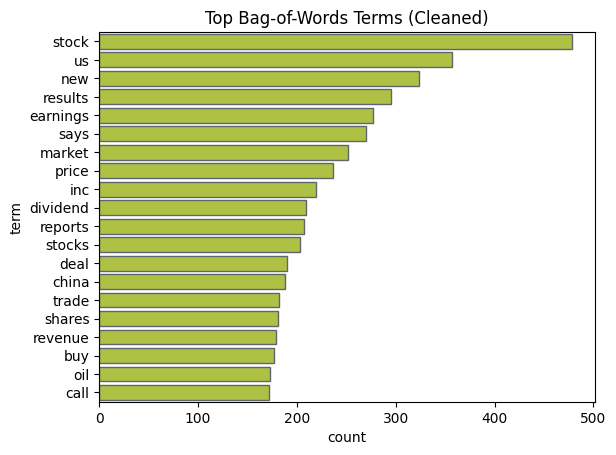

In [39]:
# Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X_train_bow.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color=color_390, edgecolor=color_431)
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

## 7.2. Word2vec

__`Step 19`__ Apply word2vec to the X_train already preprocessed.

In [45]:
X_train_cleaned_word2vec=preprocess(X_train['text'], word2vec=True)

100%|██████████| 7633/7633 [00:00<00:00, 8888.76it/s]


In [46]:
# Tokenize the tokens column for Word2Vec input
X_train_tokens = [text.split() for text in X_train['tokens']]
X_val_tokens = [text.split() for text in X_val['tokens']]

# model = Word2Vec(
#     sentences=corpus,
#     vector_size=5,    # size of the embedding vectors
#     window=2,         # context window size -  maximum distance between a target word and its context words
#     min_count=1,      # minimum word frequency that a word mus have in the corpus to be included in the modelx
#     sg=1              # 1 for skip-gram; 0 for CBOW (Predict the target word based on its context words.)
# )

# Train Word2Vec model on training
w2v_model_50 = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=dim_50, window=5, min_count=1, workers=4, sg=1)
w2v_model_100 = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=dim_100, window=5, min_count=1, workers=4, sg=1)

__`Step 20`__ Embeddings for each tweet in the corpus - average of the embeddings of each word in that tweet - suitable for models like KNN and Logistic Regression

In [47]:
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [48]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch_50 = np.array([average_embedding(text, w2v_model_50.wv, dim=dim_50) for text in X_val_cleaned])

In [49]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch_100 = np.array([average_embedding(text, w2v_model_100.wv, dim=dim_100) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch_100 = np.array([average_embedding(text, w2v_model_100.wv, dim=dim_100) for text in X_val_cleaned])

__`Step 21`__ Get the embeddings for each word - do not need to make the average - suitable for RNN and LSTM. These models accepts as inputs vectors of vectors

In [50]:
def corpus2vec(corpus, w2v):
    index_set = set(w2v.index_to_key)  # List of all words/vocabulary in the model
    word_vec = w2v.get_vector           # Creates a short cut that retrieves the embedding method for a given word
    return [
        [word_vec(word) for word in doc.split() if word in index_set]
        for doc in tqdm(corpus)
    ]

In [51]:
# these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
X_train_embeddings_from_scratch_50 = corpus2vec(X_train_cleaned, w2v_model_50.wv)
X_val_embeddings_from_scratch_50 = corpus2vec(X_val_cleaned, w2v_model_50.wv)

100%|██████████| 955/955 [00:00<00:00, 9806.11it/s]


In [52]:
# these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
X_train_embeddings_from_scratch_100 = corpus2vec(X_train_cleaned, w2v_model_100.wv)
X_val_embeddings_from_scratch_100 = corpus2vec(X_val_cleaned, w2v_model_100.wv)

100%|██████████| 955/955 [00:00<00:00, 11005.16it/s]


## 7.3. Word Vectors with Glove (Pretrained Word Vectors)

__`Step 21`__ Download the pretrained word vectors.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# we will use the one regarding twitter
glove_model_50 = gensim.downloader.load(f'glove-twitter-{dim_50}')
glove_model_100 = gensim.downloader.load(f'glove-twitter-{dim_100}')

In [ ]:
X_train_avgembeddings_glove_50 = np.array([average_embedding(text, glove_model_50, dim=dim_50) for text in X_train_cleaned])
X_val_avgembeddings_glove_50 = np.array([average_embedding(text, glove_model_50, dim=dim_50) for text in X_val_cleaned])

In [82]:
X_train_avgembeddings_glove_100 = np.array([average_embedding(text, glove_model_100, dim=dim_100) for text in X_train_cleaned])
X_val_avgembeddings_glove_100 = np.array([average_embedding(text, glove_model_100, dim=dim_100) for text in X_val_cleaned])

In [ ]:
X_train_embeddings_glove_50 = corpus2vec(X_train_cleaned, glove_model_50)
X_val_embeddings_glove_50 = corpus2vec(X_val_cleaned, glove_model_50)

100%|██████████| 955/955 [00:00<00:00, 27430.65it/s]


In [83]:
X_train_embeddings_glove_100 = corpus2vec(X_train_cleaned, glove_model_100)
X_val_embeddings_glove_100 = corpus2vec(X_val_cleaned, glove_model_100)

100%|██████████| 955/955 [00:00<00:00, 29341.54it/s]


## 7.3. Transformers (Encoders for Feature Engenineering)

Transformers Tested:

-------------- From Class -----------------
- Distilbert base uncased
- Roberta Base
- XLM Roberta Base

-------------- Out of Class ---------------
- Finbert
- Dislilbert Base Cased

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

MODEL1 = "assemblyai/distilbert-base-uncased-sst2"
MODEL2 = "cardiffnlp/twitter-roberta-base-sentiment"
MODEL3 = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
MODEL4 = "ProsusAI/finbert"
MODEL5 = "distilbert-base-cased"

In [ ]:
model1 = pipeline("feature-extraction", model=MODEL1, tokenizer=MODEL1, batch_size=16, truncation=True)
# model2 = pipeline("feature-extraction", model=MODEL2, tokenizer=MODEL2, batch_size=16, truncation=True)
# model3 = pipeline("feature-extraction", model=MODEL3, tokenizer=MODEL3, batch_size=16, truncation=True)
# model4 = pipeline("feature-extraction", model=MODEL4, tokenizer=MODEL4, batch_size=16, truncation=True)
# model5 = pipeline("feature-extraction", model=MODEL5, tokenizer=MODEL5, batch_size=16, truncation=True)

Device set to use cpu


In [ ]:
def generate_embeddings(
    texts,
    embeddings_model,
    for_sequence_model=False,
    desc="Generating Embeddings"
):
    """
    Generates either CLS embeddings (1 per text) or full token embeddings (sequence) for each input text.

    Args:
        texts (list of str): List of input texts.
        embeddings_model (callable): Hugging Face pipeline("feature-extraction", ...).
        use_cls (bool): If True, use the CLS token embedding; if False, use mean pooling.
        for_sequence_model (bool): If True, return full token-level embeddings (for RNNs).
        desc (str): tqdm progress bar description.

    Returns:
        If for_sequence_model:
            List[torch.Tensor]: Each tensor is [seq_len, hidden_dim].
        Else:
            torch.Tensor: Tensor of shape [num_texts, hidden_dim].
    """
    processed = []

    for text in tqdm(texts, desc=desc):
        output = embeddings_model(text)  # list[list[list]]
        token_embeddings = output[0]  # get token vectors from the first (and only) item in batch
        token_embeddings = torch.tensor(token_embeddings)  # shape: [seq_len, hidden_dim]

        if for_sequence_model:
            processed.append(token_embeddings)  # shape: [seq_len, hidden_dim]
        else:
            summary_vector = token_embeddings[0]  # [CLS] token embedding
            processed.append(summary_vector)

    if for_sequence_model:
        return processed
    else:
        return torch.stack(processed)  # shape: [num_texts, hidden_dim]


In [ ]:
X_train_avgembeddings_transformer1=generate_embeddings(X_train_cleaned, model1)
X_val_avgembeddings_transformer1=generate_embeddings(X_val_cleaned, model1)
# X_train_avgembeddings_transformer2=generate_embeddings(X_train_cleaned, model2)
# X_val_avgembeddings_transformer2=generate_embeddings(X_val_cleaned, model2)
# X_train_avgembeddings_transformer3=generate_embeddings(X_train_cleaned, model3)
# X_val_avgembeddings_transformer3=generate_embeddings(X_val_cleaned, model3)
# X_train_avgembeddings_transformer4=generate_embeddings(X_train_cleaned, model4)
# X_val_avgembeddings_transformer4=generate_embeddings(X_val_cleaned, model4)
# X_train_avgembeddings_transformer5=generate_embeddings(X_train_cleaned, model5)
# X_val_avgembeddings_transformer5=generate_embeddings(X_val_cleaned, model5)

Generating Embeddings: 100%|██████████| 1909/1909 [00:48<00:00, 39.36it/s]


In [ ]:
X_train_embeddings_transformer1=generate_embeddings(X_train_cleaned, model1, for_sequence_model=True)
X_val_embeddings_transformer1=generate_embeddings(X_val_cleaned, model1, for_sequence_model=True)
# X_train_embeddings_transformer2=generate_embeddings(X_train_cleaned, model2, for_sequence_model=True)
# X_val_embeddings_transformer2=generate_embeddings(X_val_cleaned, model2, for_sequence_model=True)
# X_train_embeddings_transformer3=generate_embeddings(X_train_cleaned, model3, for_sequence_model=True)
# X_val_embeddings_transformer3=generate_embeddings(X_val_cleaned, model3, for_sequence_model=True)
# X_train_embeddings_transformer4=generate_embeddings(X_train_cleaned, model4, for_sequence_model=True)
# X_val_embeddings_transformer4=generate_embeddings(X_val_cleaned, model4, for_sequence_model=True)
# X_train_embeddings_transformer5=generate_embeddings(X_train_cleaned, model5, for_sequence_model=True)
# X_val_embeddings_transformer5=generate_embeddings(X_val_cleaned, model5, for_sequence_model=True)

Generating Embeddings: 100%|██████████| 1909/1909 [00:27<00:00, 68.88it/s]


### Loading the transformers in all the dataset to then use in crossvalidation

In [ ]:
pip install sentencepiece tiktoken


     ------------------------------------- 991.5/991.5 kB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from transformers import pipeline, AutoTokenizer

# 1) Clean your texts
texts_cleaned = preprocess(X['text'])

xlm_tok = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-xlm-roberta-base-sentiment",
    use_fast=False
)

robert_base_tok=AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment",
    use_fast=False
)

finbert_tok=AutoTokenizer.from_pretrained(
    "ProsusAI/finbert",
    use_fast=False
)

distilbert_cased_tok=AutoTokenizer.from_pretrained(
    "distilbert-base-cased",
    use_fast=False
)

# 2) Initialize pipelines once
transformers_pipes = {
    'RobertaBase': pipeline(
        "feature-extraction",
        model="cardiffnlp/twitter-roberta-base-sentiment",
        tokenizer=robert_base_tok,
        use_fast=False,
        batch_size=16, truncation=True
    ),
    'XLMRoberta': pipeline(
        "feature-extraction",
        model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
        tokenizer=xlm_tok,
        use_fast=False,
        batch_size=16, truncation=True
    ),
    'Finbert': pipeline(
        "feature-extraction",
        model="ProsusAI/finbert",
        tokenizer=finbert_tok,
        use_fast=False,
        batch_size=16, truncation=True
    ),
    'DistilbertCased': pipeline(
        "feature-extraction",
        model="distilbert-base-cased",
        tokenizer=distilbert_cased_tok,
        use_fast=False,
        batch_size=16, truncation=True
    ),
}

def precompute_embeddings(texts, pipes, sequence=False):
    """
    texts: list of cleaned strings
    pipes: dict[name -> HF pipeline]
    sequence: if False, extracts CLS only; if True, returns list-of-lists of token vectors
    returns: dict[name -> np.array or list]
    """
    cache = {}
    for name, pipe in pipes.items():
        # generate_embeddings already handles sequence vs cls
        print('loading', name)
        emb = generate_embeddings(texts, pipe, for_sequence_model=sequence)
        if not sequence:
            # emb is a torch.Tensor of shape (N, hidden_dim)
            cache[name] = emb.numpy()
        else:
            # emb is a list of N tensors [seq_len_i, hidden_dim]
            cache[name] = [t.numpy() for t in emb]
    return cache

# Example usage:
# - CLS embeddings:
precomputed_cls = precompute_embeddings(texts_cleaned, transformers_pipes, sequence=False)
# - Sequence embeddings (for RNNs):
precomputed_seq = precompute_embeddings(texts_cleaned, transformers_pipes, sequence=True)


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fallin

loading RobertaBase


Generating Embeddings: 100%|██████████| 9543/9543 [05:58<00:00, 26.60it/s]


loading XLMRoberta


Generating Embeddings: 100%|██████████| 9543/9543 [05:42<00:00, 27.89it/s]


loading Finbert


Generating Embeddings: 100%|██████████| 9543/9543 [06:28<00:00, 24.59it/s]


loading DistilbertCased


Generating Embeddings: 100%|██████████| 9543/9543 [02:19<00:00, 68.54it/s]


loading RobertaBase


Generating Embeddings: 100%|██████████| 9543/9543 [05:03<00:00, 31.44it/s]


loading XLMRoberta


Generating Embeddings: 100%|██████████| 9543/9543 [03:46<00:00, 42.09it/s]


loading Finbert


Generating Embeddings: 100%|██████████| 9543/9543 [03:48<00:00, 41.69it/s]


loading DistilbertCased


Generating Embeddings: 100%|██████████| 9543/9543 [02:03<00:00, 77.16it/s]


In [ ]:
precomputed_cls

{'RobertaBase': array([[-0.42970073, -1.1109345 , -0.02756199, ..., -1.0715039 ,
         -0.20665328, -0.5011792 ],
        [-0.2655887 , -0.46534184, -0.14403622, ..., -2.0034702 ,
         -0.17918397,  0.04349802],
        [-0.56827056, -0.5792684 ,  0.08447295, ..., -1.4907732 ,
         -0.22760093, -0.35070103],
        ...,
        [-0.4038158 , -0.3929749 , -0.17512104, ..., -0.5585281 ,
          0.02967115, -0.35061273],
        [-0.1982592 , -0.28932762, -0.0427763 , ..., -1.8701763 ,
         -0.4788909 ,  0.31163454],
        [-0.05667178, -0.4547117 , -0.21518792, ..., -1.6193632 ,
         -0.3267693 ,  0.3852179 ]], dtype=float32),
 'XLMRoberta': array([[ 0.09361389,  0.10806807, -0.07811372, ..., -0.423998  ,
          0.1361395 ,  0.14344513],
        [ 0.27077088,  0.6768176 ,  0.06961114, ..., -1.0150374 ,
          0.08878443, -0.37401155],
        [-0.00617623,  0.80134755, -0.20768201, ..., -0.82278866,
          0.50034875, -0.2689569 ],
        ...,
        [ 

In [ ]:
precomputed_seq

{'RobertaBase': [array([[-0.42970073, -1.1109345 , -0.02756199, ..., -1.0715039 ,
          -0.20665328, -0.5011792 ],
         [ 0.4606501 , -1.0275838 , -0.29089043, ..., -1.5834193 ,
          -0.7846453 , -0.05395483],
         [-0.14234526, -0.5803351 ,  0.14066109, ..., -2.8323646 ,
          -0.17918882, -0.28421438],
         ...,
         [-0.6148399 , -1.8760471 , -0.308156  , ..., -2.056573  ,
          -0.25655684, -0.34869406],
         [-0.68239564, -1.553741  , -0.18197966, ..., -1.3202776 ,
          -0.24702369, -0.11808112],
         [-0.432531  , -1.0988055 , -0.02257469, ..., -1.0500473 ,
          -0.20895174, -0.4992124 ]], dtype=float32),
  array([[-0.2655887 , -0.46534184, -0.14403622, ..., -2.0034702 ,
          -0.17918397,  0.04349802],
         [ 0.58719516, -0.53979045, -0.27898845, ..., -2.5759714 ,
          -0.6944563 ,  0.23509358],
         [ 0.1460115 , -0.57113105, -0.13126472, ..., -1.7016826 ,
          -0.40357932,  0.05408001],
         ...,
    

# 8. Classification Models

X_train_avgembeddings_(...) - for KNN and logistic regression models. Each tweet is a vector with the average embeddings of each word
X_train_embeddings_(...) - for RNN and LTSM. Each tweet is a vector of vector. Each word is an embedding, all embaddings have the same size. It is needed padding, done below in the RNN and LSTM section.

## 8.1. KNN Classifier, Logistic Regression

### Defining functions

In [ ]:
feature_sets = {
    "BoW": (X_train_bow, X_val_bow),
    "Word2Vec": (X_train_avgembeddings_from_scratch_100, X_val_avgembeddings_from_scratch_100),
    "GloVe": (X_train_avgembeddings_glove_100, X_val_avgembeddings_glove_100),
    # "distilbert-base-uncased": (X_train_avgembeddings_transformer1, X_val_avgembeddings_transformer1),
    # "finbert": (X_train_avgembeddings_transformer4, X_val_avgembeddings_transformer4)
}

In [ ]:
knn_configs = [
    {"n_neighbors": 10, "metric": "cosine", "weights": "uniform"},
    {"n_neighbors": 5, "metric": "cosine", "weights": "distance"},
    {"n_neighbors": 10, "metric": "cosine", "weights": "distance"},
    {"n_neighbors": 5, "metric": "euclidean", "weights": "distance"}
]

In [ ]:
logreg_configs = [
    {"max_iter": 1000, "solver": "lbfgs"},
    {"max_iter": 1000, "solver": "saga"},
    {"max_iter": 1000, "solver": "liblinear"}
]

In [ ]:
def evaluate_and_print(model, X_train, y_train, X_val, y_val, model_name, rep_name, config):
    print(f"\n Model: {model_name}, Embedding: {rep_name}, Config: {config}")
    print("--------------------------------------------------------------------------------------")

    results = {}

    # --- TRAINING METRICS ---
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\nTRAINING METRICS")
    print(f"\nMacro Avg F1-score: {train_report['macro avg']['f1-score']:.4f}")

    # --- VALIDATION METRICS ---
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\nVALIDATION METRICS")
    print(f"\nMacro Avg F1-score: {val_report['macro avg']['f1-score']:.4f}")

    # --- Return all scores for storage ---
    results = {
        "model": model_name,
        "embedding": rep_name,
        "config": config,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_f1": train_report["macro avg"]["f1-score"],
        "val_f1": val_report["macro avg"]["f1-score"],
        "f1_gap": train_report["macro avg"]["f1-score"] - val_report["macro avg"]["f1-score"]
    }

    return results

### KNN

In [ ]:
results_final = []

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in knn_configs:
        # Initialize model with current hyperparameters
        knn = KNeighborsClassifier(**config)
        # Train and predict
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        # Evaluate
        results = evaluate_and_print(knn, X_train, y_train, X_val, y_val, "KNN", rep_name, config)

        config_str = ', '.join(f"{k}={v}" for k, v in sorted(config.items()))

        results_final.append({
            "prepro + model": rep_name+ " " +config_str,
            "train_f1": results["train_f1"],
            "val_f1": results["val_f1"]
        })

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7998

Macro Avg F1-score: 0.7081

📗 VALIDATION METRICS
Accuracy: 0.7382

Macro Avg F1-score: 0.6124
--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9976

Macro Avg F1-score: 0.9969

📗 VALIDATION METRICS
Accuracy: 0.7487

Macro Avg F1-score: 0.6387
--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}


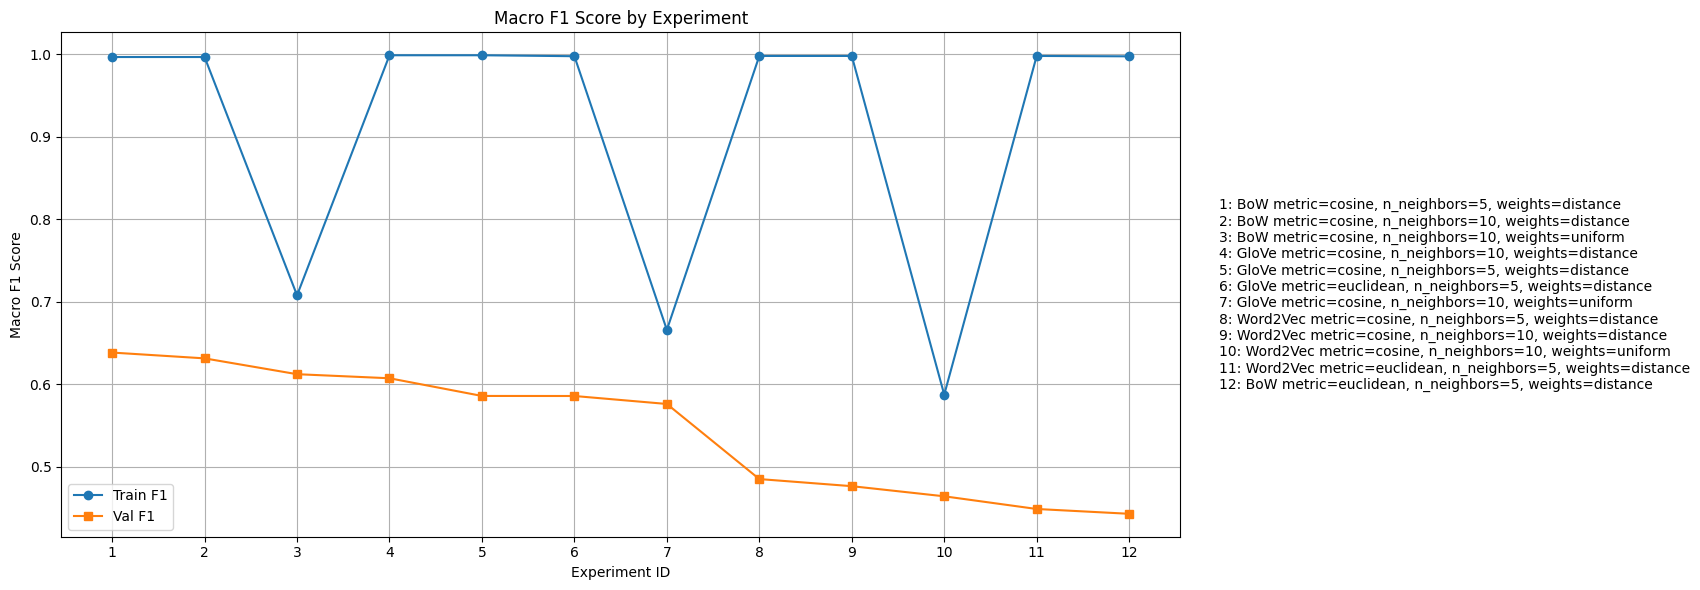

In [ ]:
# Convert results_final to a DataFrame
df_results = pd.DataFrame(results_final)

# Sort by validation F1 if desired
df_results = df_results.sort_values("val_f1", ascending=False).reset_index(drop=True)

# Create numerical labels for x-axis
df_results["experiment_id"] = range(1, len(df_results) + 1)

# Create mapping for legend
legend_labels = [
    f"{i+1}: {name}" for i, name in enumerate(df_results["prepro + model"])
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_results["experiment_id"], df_results["train_f1"], marker='o', label="Train F1")
plt.plot(df_results["experiment_id"], df_results["val_f1"], marker='s', label="Val F1")

# Labels and formatting
plt.xticks(df_results["experiment_id"])  # just numbers on x-axis
plt.xlabel("Experiment ID")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score by Experiment")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Add a custom legend as text box
legend_text = "\n".join(legend_labels)
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center')  # side legend

# Show plot
plt.show()

### Logistic

In [ ]:
results_logreg = []
from sklearn.linear_model import LogisticRegression

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in logreg_configs:
        clf = LogisticRegression(**config)
        clf.fit(X_train, y_train)
        results = evaluate_and_print(clf, X_train, y_train, X_val, y_val, "Logistic Regression", rep_name, config)
        config_str = ', '.join(f"{k}={v}" for k, v in sorted(config.items()))

        results_logreg.append({
            "prepro + model": rep_name+ " " +config_str,
            "train_f1": results["train_f1"],
            "val_f1": results["val_f1"]
        })

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9756

Macro Avg F1-score: 0.9671

📗 VALIDATION METRICS
Accuracy: 0.7843

Macro Avg F1-score: 0.6722
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9755

Macro Avg F1-score: 0.9670

📗 VALIDATION METRICS
Accuracy: 0.7843

Macro Avg F1-score: 0.6722
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'liblinear'}
----------------------

c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6668

Macro Avg F1-score: 0.3633

📗 VALIDATION METRICS
Accuracy: 0.6513

Macro Avg F1-score: 0.3366
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6666

Macro Avg F1-score: 0.3600

📗 VALIDATION METRICS
Accuracy: 0.6545

Macro Avg F1-score: 0.3365


c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7249

Macro Avg F1-score: 0.5722

📗 VALIDATION METRICS
Accuracy: 0.7162

Macro Avg F1-score: 0.5560
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7245

Macro Avg F1-score: 0.5720

📗 VALIDATION METRICS
Accuracy: 0.7152

Macro Avg F1-score: 0.5553
--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'liblinear'}
----------------

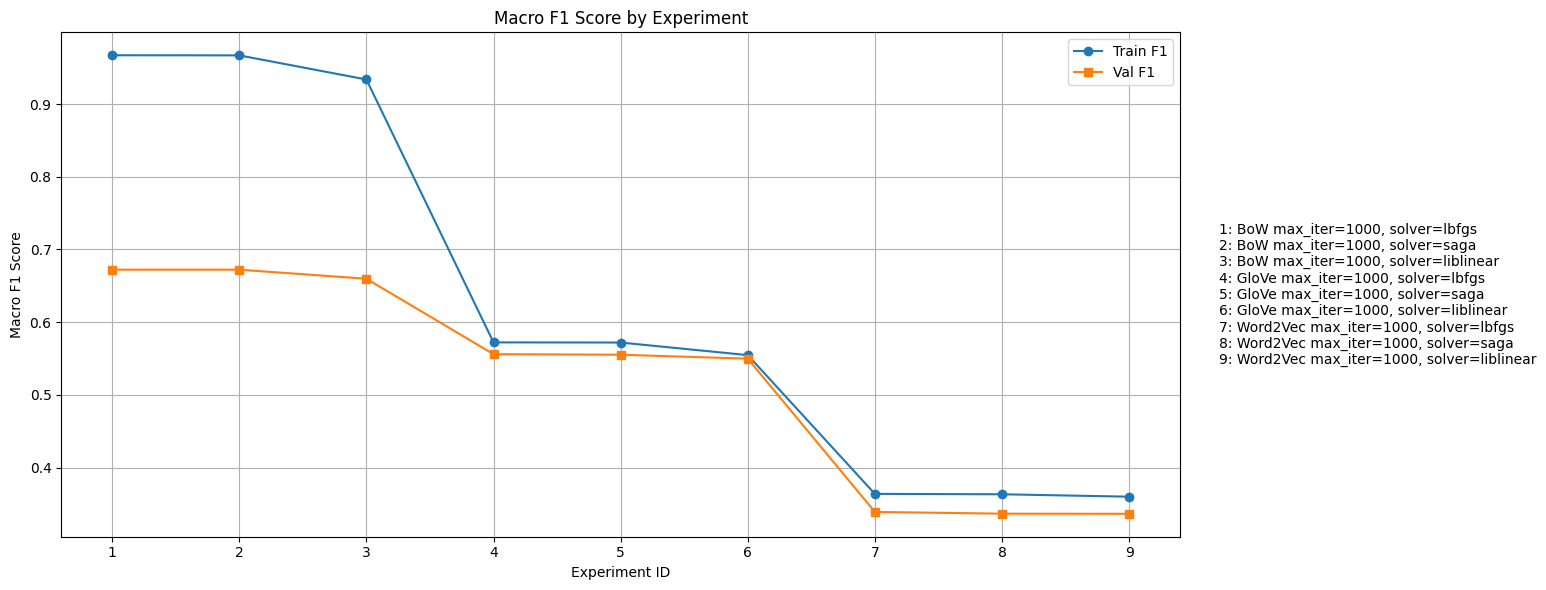

In [ ]:
# Convert results_final to a DataFrame
df_results = pd.DataFrame(results_logreg)

# Sort by validation F1 if desired
df_results = df_results.sort_values("val_f1", ascending=False).reset_index(drop=True)

# Create numerical labels for x-axis
df_results["experiment_id"] = range(1, len(df_results) + 1)

# Create mapping for legend
legend_labels = [
    f"{i+1}: {name}" for i, name in enumerate(df_results["prepro + model"])
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_results["experiment_id"], df_results["train_f1"], marker='o', label="Train F1")
plt.plot(df_results["experiment_id"], df_results["val_f1"], marker='s', label="Val F1")

# Labels and formatting
plt.xticks(df_results["experiment_id"])  # just numbers on x-axis
plt.xlabel("Experiment ID")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Score by Experiment")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Add a custom legend as text box
legend_text = "\n".join(legend_labels)
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, va='center')  # side legend

# Show plot
plt.show()

### Feature Enginering CrossValidation

In [ ]:
feateng_list_knn=['BOW', 'Word2Vec', 'Glove', 'RobertaBase', 'XLMRoberta', 'Finbert', 'DistilbertCased']

In [176]:
df_cv_knn=feateng_crossval(
    X_train_val, y_train_val,
    feateng_list=feateng_list_knn,
    model_name='KNN',
    precomputed_cls=precomputed_cls,
    precomputed_seq=precomputed_seq, 
    cv=9,
    seed=SEED)

In [177]:
df_cv_knn

model          feateng  fold  train_f1   test_f1  train_acc  test_acc
0    KNN              BOW     1  0.753926  0.623748   0.823791  0.730890
1    KNN              BOW     2  0.757539  0.606915   0.826805  0.710995
2    KNN              BOW     3  0.757490  0.608368   0.828137  0.719078
3    KNN              BOW     4  0.762765  0.586826   0.829447  0.709644
4    KNN              BOW     5  0.763823  0.552530   0.831019  0.686583
..   ...              ...   ...       ...       ...        ...       ...
58   KNN  DistilbertCased     5  0.520775  0.339771   0.673304  0.548218
59   KNN  DistilbertCased     6  0.521073  0.321152   0.673304  0.536688
60   KNN  DistilbertCased     7  0.519187  0.327668   0.674352  0.522013
61   KNN  DistilbertCased     8  0.530245  0.323226   0.677757  0.532495
62   KNN  DistilbertCased     9  0.521232  0.332949   0.673304  0.530398

[63 rows x 7 columns]

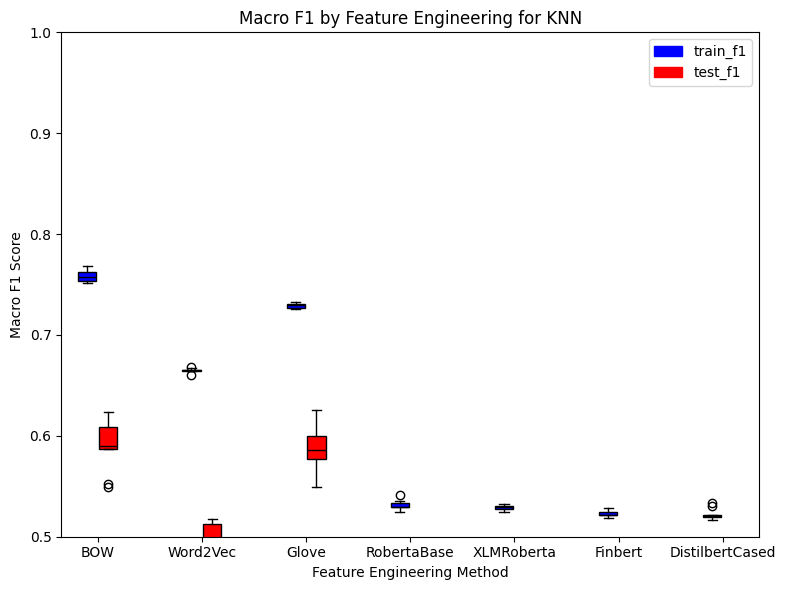

In [178]:
plot_f1_by_feateng(df_cv_knn,'KNN')

In [179]:
feateng_list_logreg=['BOW', 'Word2Vec', 'Glove', 'RobertaBase', 'XLMRoberta', 'Finbert', 'DistilbertCased']

In [180]:
df_cv_logreg=feateng_crossval(
    X_train_val, y_train_val,
    feateng_list=feateng_list_logreg,
    model_name='LogReg',
    precomputed_cls=precomputed_cls,
    precomputed_seq=precomputed_seq, 
    cv=9,
    seed=SEED)

c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\carol\Documents\mestrado\tx_mng\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [181]:
df_cv_logreg

model          feateng  fold  train_f1   test_f1  train_acc  test_acc
0   LogReg              BOW     1  0.956830  0.615010   0.968034  0.749738
1   LogReg              BOW     2  0.959459  0.662081   0.969868  0.776963
2   LogReg              BOW     3  0.958660  0.630435   0.969479  0.757862
3   LogReg              BOW     4  0.960045  0.589021   0.970658  0.736897
4   LogReg              BOW     5  0.957914  0.590843   0.969217  0.738994
..     ...              ...   ...       ...       ...        ...       ...
58  LogReg  DistilbertCased     5  0.291539  0.265473   0.651821  0.646751
59  LogReg  DistilbertCased     6  0.302136  0.264940   0.654703  0.633124
60  LogReg  DistilbertCased     7  0.301561  0.270381   0.655358  0.633124
61  LogReg  DistilbertCased     8  0.292517  0.272201   0.652345  0.635220
62  LogReg  DistilbertCased     9  0.308687  0.262329   0.656275  0.635220

[63 rows x 7 columns]

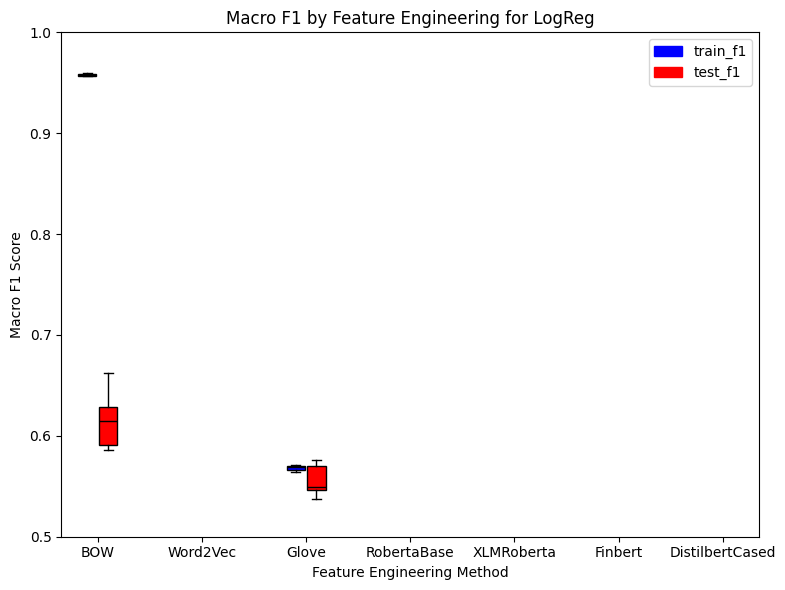

In [182]:
plot_f1_by_feateng(df_cv_logreg,'LogReg')

## 8.3. RNN & LSTM

### Pad Sequences and one hot encoding

Needed for RNN and LSTM so that all the sentences have the same lenght
Embeddings with zero are added to the end of each tweet so that they all have lenght equal to the lenght of the longer tweet

In [84]:
#get list with lenghts of sentences
train_len = []
for i in X_train_embeddings_glove_100:
    train_len.append(len(i))

In [85]:
max(train_len)

24

In [86]:
X_train_pad = pad_sequences(maxlen=max(train_len),sequences=X_train_embeddings_glove_100, padding="post", dtype='float64')

In [87]:
X_train_pad.shape

(7633, 24, 100)

In [185]:
len(X_train_pad[0][0])

100

In [88]:
X_val_pad = pad_sequences(maxlen=max(train_len),sequences=X_val_embeddings_glove_100, padding="post", dtype='float64')

In [89]:
print(X_train_pad[0][:max(train_len)])

[[ 0.0043546   0.25828001  0.88463998 ... -0.14030001  0.18065
   0.030999  ]
 [ 0.29886001  0.43645     0.38124999 ... -0.18531001 -0.51027
   0.29067001]
 [-0.15644     0.68322998  0.50617999 ... -0.75022    -0.17038
  -0.37597001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [90]:
y_train_encoded = tf.one_hot(y_train, depth=3)

In [91]:
len(y_train)

7633

In [92]:
y_val_encoded = tf.one_hot(y_val, depth=3)

In [93]:
len(y_val)

955

In [94]:
len(X_val_pad)

955

### Model Initialization and training

In [106]:
input_ = Input(shape=(max(train_len), dim_100))
mask = Masking(mask_value=0)(input_)

# Bi-LSTM now returns just the final output vector [B, 2*units]
lstm_out = Bidirectional(LSTM(units=32, return_sequences=False))(mask)

bn = BatchNormalization()(lstm_out)
drop = Dropout(0.4)(bn)
act  = Dense(3,
             activation='softmax',
             kernel_regularizer=regularizers.l2(1e-4)
            )(drop)

model = Model(input_, act)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=[CategoricalAccuracy(name="accuracy"), F1Score(average="macro", name="f1_score")])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 24, 100)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 24, 100)   │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_9 (Masking) │ (None, 24, 100)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_9 (Any)         │ (None, 24)        │          0 │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 64)        │     34,048 │ masking_9[0][0],  │
│ (Bidirectional)     │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ bidirectional_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        195 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,499 (134.76 KB)

 Trainable params: 34,371 (134.26 KB)

 Non-trainable params: 128 (512.00 B)

In [107]:
history=model.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_val_pad, y_val_encoded),
    batch_size=16,
    epochs=20,
    verbose=1
)

Epoch 1/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3824 - f1_score: 0.3350 - loss: 1.5973 - val_accuracy: 0.5571 - val_f1_score: 0.4642 - val_loss: 1.0015
Epoch 2/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5267 - f1_score: 0.4429 - loss: 1.1867 - val_accuracy: 0.6356 - val_f1_score: 0.5108 - val_loss: 0.8758
Epoch 3/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5871 - f1_score: 0.4804 - loss: 0.9999 - val_accuracy: 0.6597 - val_f1_score: 0.5211 - val_loss: 0.8009
Epoch 4/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6199 - f1_score: 0.4918 - loss: 0.9256 - val_accuracy: 0.6838 - val_f1_score: 0.5465 - val_loss: 0.7594
Epoch 5/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6498 - f1_score: 0.5148 - loss: 0.8759 - val_accuracy: 0.6921 - val_f1_score: 0.5482 - val_loss: 0.7344
Epoch 6/20
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6642 - f1_score: 0.5220 - loss: 0.8176 - val_accuracy: 0.6984 - val_f1_score: 0.5553

In [ ]:
df_history = pd.DataFrame(history.history)
# Add epoch number (starting from 1)
df_history['epoch'] = range(1, len(df_history) + 1)
df_history = df_history[['epoch'] + [col for col in df_history.columns if col != 'epoch']]
df_history.head()

epoch  accuracy  f1_score      loss  val_accuracy  val_f1_score  val_loss
0      1  0.509760  0.377931  1.464185      0.663874      0.391506  0.852801
1      2  0.576575  0.415649  1.231468      0.676440      0.421741  0.842602
2      3  0.596882  0.429536  1.125113      0.689005      0.462540  0.804256
3      4  0.618892  0.456467  1.049479      0.697382      0.479239  0.776977
4      5  0.629897  0.468914  0.984191      0.697382      0.493433  0.751164

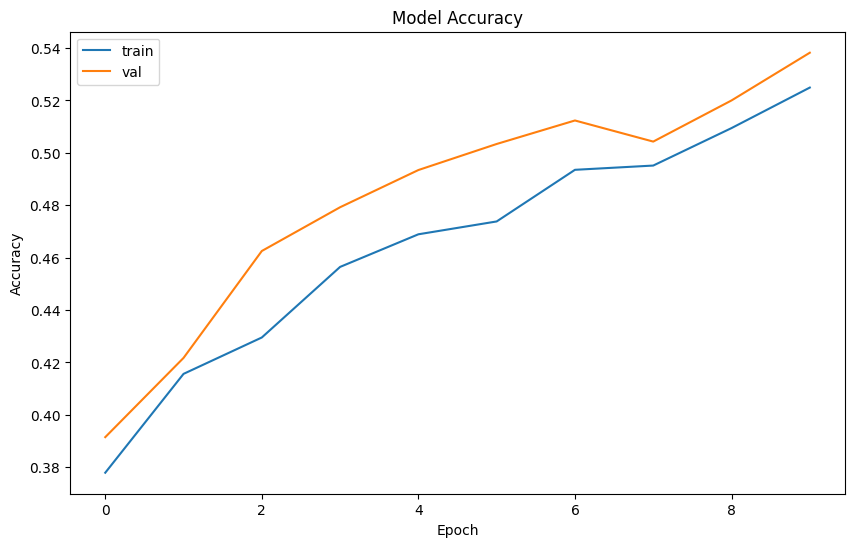

In [ ]:
plt.figure(figsize =(10, 6))
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def get_metric(X_test, y_test, model_name):
    print(f"\nEvaluating model: {model_name}")
    #model = load_model(model_name)
    pred_y = model.predict(X_test)

    y_pred = []
    for doc in pred_y:
        y_pred.append(np.argmax(doc, axis=None, out=None))

    train_report = classification_report(y_test, y_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    # for label in ['bearish', 'bullish', 'neutral']:
    #     metrics = train_report[label]
    #     print(f"\nClass: {label}")
    #     print(f"  Precision: {metrics['precision']:.4f}")
    #     print(f"  Recall:    {metrics['recall']:.4f}")
    #     print(f"  F1-score:  {metrics['f1-score']:.4f}")
    # print(f"\nMacro Avg F1-score: {train_report['macro avg']['f1-score']:.4f}")


    return round(train_report['macro avg']['precision'], 4), round(train_report['macro avg']['recall'], 4), round(train_report['macro avg']['f1-score'], 4)

In [ ]:
get_metric(X_val_pad, y_val, model)


Evaluating model: <Functional name=functional_12, built=True>
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Class: bearish
  Precision: 0.6000
  Recall:    0.2292
  F1-score:  0.3317

Class: bullish
  Precision: 0.5854
  Recall:    0.3731
  F1-score:  0.4557

Class: neutral
  Precision: 0.7426
  Recall:    0.9337
  F1-score:  0.8272

Macro Avg F1-score: 0.5382


(0.6427, 0.512, 0.5382)

### Feature Enginering CrossValidation

In [183]:
feateng_list_lstm=['Word2Vec', 'Glove', 'RobertaBase', 'XLMRoberta', 'Finbert', 'DistilbertCased']

In [192]:
df_cv_lstm=feateng_crossval(
    X_train_val, y_train_val,
    feateng_list=feateng_list_lstm,
    model_name='LSTM',
    precomputed_cls=precomputed_cls,
    precomputed_seq=precomputed_seq, 
    cv=9,
    seed=SEED)

100%|██████████| 955/955 [00:00<00:00, 191150.58it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3631 - f1_score: 0.3232 - loss: 1.3112 - val_accuracy: 0.6649 - val_f1_score: 0.4135 - val_loss: 0.9188
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5372 - f1_score: 0.4122 - loss: 1.0216 - val_accuracy: 0.6649 - val_f1_score: 0.4080 - val_loss: 0.8542
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5936 - f1_score: 0.4251 - loss: 0.9498 - val_accuracy: 0.6723 - val_f1_score: 0.4002 - val_loss: 0.8140
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6348 - f1_score: 0.4227 - loss: 0.8783 - val_accuracy: 0.6743 - val_f1_score: 0.3957 - val_loss: 0.8059
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6369 - f1_score: 0.3951 - loss: 0.8564 - val_accuracy: 0.6764 - val_f1_score: 0.3931 - val_loss: 0.8015
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6571 - f1_score: 0.4061 - loss: 0.8423 - val_accuracy: 0.6723 - val_f1_score: 0

100%|██████████| 955/955 [00:00<00:00, 290026.81it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4033 - f1_score: 0.3446 - loss: 1.2788 - val_accuracy: 0.6534 - val_f1_score: 0.4229 - val_loss: 0.9099
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5566 - f1_score: 0.4185 - loss: 1.0302 - val_accuracy: 0.6649 - val_f1_score: 0.4208 - val_loss: 0.8331
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5981 - f1_score: 0.4067 - loss: 0.9470 - val_accuracy: 0.6691 - val_f1_score: 0.4433 - val_loss: 0.8279
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6338 - f1_score: 0.4146 - loss: 0.8891 - val_accuracy: 0.6806 - val_f1_score: 0.4460 - val_loss: 0.8014
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6411 - f1_score: 0.3944 - loss: 0.8771 - val_accuracy: 0.6785 - val_f1_score: 0.4472 - val_loss: 0.7996
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6529 - f1_score: 0.3986 - loss: 0.8525 - val_accuracy: 0.6785 - val_f1_score: 0.39

100%|██████████| 954/954 [00:00<00:00, 189980.34it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3956 - f1_score: 0.3426 - loss: 1.2810 - val_accuracy: 0.6478 - val_f1_score: 0.4218 - val_loss: 0.9233
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5509 - f1_score: 0.4153 - loss: 1.0227 - val_accuracy: 0.6614 - val_f1_score: 0.4429 - val_loss: 0.8421
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6027 - f1_score: 0.4128 - loss: 0.9292 - val_accuracy: 0.6730 - val_f1_score: 0.4510 - val_loss: 0.8229
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6394 - f1_score: 0.4217 - loss: 0.8748 - val_accuracy: 0.6824 - val_f1_score: 0.4377 - val_loss: 0.7952
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6527 - f1_score: 0.4140 - loss: 0.8555 - val_accuracy: 0.6803 - val_f1_score: 0.4383 - val_loss: 0.7948
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6614 - f1_score: 0.4090 - loss: 0.8393 - val_accuracy: 0.6771 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 159030.48it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3935 - f1_score: 0.3368 - loss: 1.2981 - val_accuracy: 0.6352 - val_f1_score: 0.3879 - val_loss: 0.9203
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5482 - f1_score: 0.3993 - loss: 1.0415 - val_accuracy: 0.6415 - val_f1_score: 0.3884 - val_loss: 0.8768
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6098 - f1_score: 0.4175 - loss: 0.9399 - val_accuracy: 0.6593 - val_f1_score: 0.3919 - val_loss: 0.8326
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6389 - f1_score: 0.4122 - loss: 0.8901 - val_accuracy: 0.6614 - val_f1_score: 0.3755 - val_loss: 0.8211
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6476 - f1_score: 0.3911 - loss: 0.8738 - val_accuracy: 0.6698 - val_f1_score: 0.3965 - val_loss: 0.8132
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6665 - f1_score: 0.3974 - loss: 0.8393 - val_accuracy: 0.6667 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 190895.76it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3730 - f1_score: 0.3240 - loss: 1.3157 - val_accuracy: 0.6321 - val_f1_score: 0.4218 - val_loss: 0.9547
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5345 - f1_score: 0.4040 - loss: 1.0716 - val_accuracy: 0.6488 - val_f1_score: 0.4028 - val_loss: 0.8889
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6015 - f1_score: 0.4074 - loss: 0.9558 - val_accuracy: 0.6488 - val_f1_score: 0.3993 - val_loss: 0.8638
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6256 - f1_score: 0.4045 - loss: 0.9179 - val_accuracy: 0.6541 - val_f1_score: 0.3647 - val_loss: 0.8349
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6455 - f1_score: 0.3954 - loss: 0.8843 - val_accuracy: 0.6593 - val_f1_score: 0.3690 - val_loss: 0.8239
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6504 - f1_score: 0.3929 - loss: 0.8647 - val_accuracy: 0.6667 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 236068.79it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4041 - f1_score: 0.3408 - loss: 1.2557 - val_accuracy: 0.6488 - val_f1_score: 0.4098 - val_loss: 0.9357
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5457 - f1_score: 0.4006 - loss: 1.0306 - val_accuracy: 0.6541 - val_f1_score: 0.4061 - val_loss: 0.8716
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6068 - f1_score: 0.4080 - loss: 0.9422 - val_accuracy: 0.6593 - val_f1_score: 0.3930 - val_loss: 0.8305
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6312 - f1_score: 0.4006 - loss: 0.8869 - val_accuracy: 0.6709 - val_f1_score: 0.3982 - val_loss: 0.8023
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6440 - f1_score: 0.3920 - loss: 0.8659 - val_accuracy: 0.6688 - val_f1_score: 0.4026 - val_loss: 0.8032
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6520 - f1_score: 0.3830 - loss: 0.8497 - val_accuracy: 0.6761 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 237540.28it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4289 - f1_score: 0.3536 - loss: 1.2738 - val_accuracy: 0.6394 - val_f1_score: 0.3889 - val_loss: 0.9194
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5662 - f1_score: 0.4218 - loss: 1.0064 - val_accuracy: 0.6509 - val_f1_score: 0.3984 - val_loss: 0.8674
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6153 - f1_score: 0.4249 - loss: 0.9231 - val_accuracy: 0.6604 - val_f1_score: 0.3476 - val_loss: 0.8322
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6446 - f1_score: 0.4139 - loss: 0.8650 - val_accuracy: 0.6614 - val_f1_score: 0.3530 - val_loss: 0.8310
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6589 - f1_score: 0.4147 - loss: 0.8421 - val_accuracy: 0.6635 - val_f1_score: 0.3595 - val_loss: 0.8185
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6723 - f1_score: 0.4216 - loss: 0.8191 - val_accuracy: 0.6572 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 238688.02it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3846 - f1_score: 0.3302 - loss: 1.2645 - val_accuracy: 0.6321 - val_f1_score: 0.3367 - val_loss: 0.9238
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5557 - f1_score: 0.4159 - loss: 0.9987 - val_accuracy: 0.6310 - val_f1_score: 0.3551 - val_loss: 0.8750
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6082 - f1_score: 0.4153 - loss: 0.9329 - val_accuracy: 0.6405 - val_f1_score: 0.3390 - val_loss: 0.8418
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6386 - f1_score: 0.4100 - loss: 0.8763 - val_accuracy: 0.6426 - val_f1_score: 0.3286 - val_loss: 0.8310
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6499 - f1_score: 0.4068 - loss: 0.8600 - val_accuracy: 0.6415 - val_f1_score: 0.3187 - val_loss: 0.8215
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6569 - f1_score: 0.3958 - loss: 0.8371 - val_accuracy: 0.6447 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 182045.77it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3931 - f1_score: 0.3415 - loss: 1.3545 - val_accuracy: 0.6604 - val_f1_score: 0.3949 - val_loss: 0.8948
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5277 - f1_score: 0.3930 - loss: 1.0474 - val_accuracy: 0.6646 - val_f1_score: 0.4081 - val_loss: 0.8247
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5959 - f1_score: 0.4053 - loss: 0.9549 - val_accuracy: 0.6751 - val_f1_score: 0.3998 - val_loss: 0.8036
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6303 - f1_score: 0.4118 - loss: 0.8987 - val_accuracy: 0.6730 - val_f1_score: 0.3761 - val_loss: 0.7944
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6417 - f1_score: 0.4001 - loss: 0.8863 - val_accuracy: 0.6782 - val_f1_score: 0.3909 - val_loss: 0.7938
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6501 - f1_score: 0.3934 - loss: 0.8599 - val_accuracy: 0.6782 - val_f1_score: 

100%|██████████| 955/955 [00:00<00:00, 26305.13it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3701 - f1_score: 0.3354 - loss: 1.5910 - val_accuracy: 0.5539 - val_f1_score: 0.4538 - val_loss: 0.9713
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4843 - f1_score: 0.4141 - loss: 1.1958 - val_accuracy: 0.6283 - val_f1_score: 0.5101 - val_loss: 0.8561
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5564 - f1_score: 0.4661 - loss: 1.0091 - val_accuracy: 0.6764 - val_f1_score: 0.5452 - val_loss: 0.7782
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6070 - f1_score: 0.4984 - loss: 0.9274 - val_accuracy: 0.6932 - val_f1_score: 0.5564 - val_loss: 0.7442
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6291 - f1_score: 0.5074 - loss: 0.8639 - val_accuracy: 0.7058 - val_f1_score: 0.5567 - val_loss: 0.7138
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6623 - f1_score: 0.5340 - loss: 0.8128 - val_accuracy: 0.7141 - val_f1_score: 0.

100%|██████████| 955/955 [00:00<00:00, 24768.64it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3708 - f1_score: 0.3280 - loss: 1.6377 - val_accuracy: 0.5801 - val_f1_score: 0.4727 - val_loss: 0.9727
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4988 - f1_score: 0.4217 - loss: 1.2030 - val_accuracy: 0.6398 - val_f1_score: 0.5127 - val_loss: 0.8655
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5726 - f1_score: 0.4730 - loss: 1.0151 - val_accuracy: 0.6733 - val_f1_score: 0.5277 - val_loss: 0.7741
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6184 - f1_score: 0.5023 - loss: 0.9226 - val_accuracy: 0.7016 - val_f1_score: 0.5521 - val_loss: 0.7307
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6393 - f1_score: 0.5153 - loss: 0.8713 - val_accuracy: 0.7079 - val_f1_score: 0.5526 - val_loss: 0.7052
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6573 - f1_score: 0.5171 - loss: 0.8270 - val_accuracy: 0.7183 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 26730.48it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3537 - f1_score: 0.3172 - loss: 1.6207 - val_accuracy: 0.4927 - val_f1_score: 0.4157 - val_loss: 1.0468
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4880 - f1_score: 0.4133 - loss: 1.1836 - val_accuracy: 0.5922 - val_f1_score: 0.4767 - val_loss: 0.9216
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5650 - f1_score: 0.4672 - loss: 1.0139 - val_accuracy: 0.6447 - val_f1_score: 0.5155 - val_loss: 0.8351
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6136 - f1_score: 0.4980 - loss: 0.9172 - val_accuracy: 0.6604 - val_f1_score: 0.5153 - val_loss: 0.7890
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6486 - f1_score: 0.5226 - loss: 0.8492 - val_accuracy: 0.6876 - val_f1_score: 0.5337 - val_loss: 0.7561
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6596 - f1_score: 0.5250 - loss: 0.8145 - val_accuracy: 0.6981 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 25678.92it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4109 - f1_score: 0.3640 - loss: 1.5357 - val_accuracy: 0.5388 - val_f1_score: 0.4331 - val_loss: 0.9829
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5025 - f1_score: 0.4184 - loss: 1.1943 - val_accuracy: 0.6153 - val_f1_score: 0.4899 - val_loss: 0.8784
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5671 - f1_score: 0.4626 - loss: 1.0212 - val_accuracy: 0.6384 - val_f1_score: 0.4961 - val_loss: 0.8063
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6260 - f1_score: 0.5016 - loss: 0.9065 - val_accuracy: 0.6688 - val_f1_score: 0.5005 - val_loss: 0.7598
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6525 - f1_score: 0.5176 - loss: 0.8469 - val_accuracy: 0.6887 - val_f1_score: 0.5218 - val_loss: 0.7349
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6684 - f1_score: 0.5323 - loss: 0.8150 - val_accuracy: 0.6845 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 26127.62it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3383 - f1_score: 0.3011 - loss: 1.6910 - val_accuracy: 0.5335 - val_f1_score: 0.4366 - val_loss: 1.0088
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4821 - f1_score: 0.4136 - loss: 1.2292 - val_accuracy: 0.6205 - val_f1_score: 0.5036 - val_loss: 0.8984
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5510 - f1_score: 0.4617 - loss: 1.0419 - val_accuracy: 0.6436 - val_f1_score: 0.5132 - val_loss: 0.8185
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6079 - f1_score: 0.4961 - loss: 0.9234 - val_accuracy: 0.6792 - val_f1_score: 0.5409 - val_loss: 0.7683
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6340 - f1_score: 0.5183 - loss: 0.8707 - val_accuracy: 0.6866 - val_f1_score: 0.5491 - val_loss: 0.7410
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6562 - f1_score: 0.5291 - loss: 0.8274 - val_accuracy: 0.7034 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 25783.82it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3941 - f1_score: 0.3389 - loss: 1.5536 - val_accuracy: 0.5860 - val_f1_score: 0.4734 - val_loss: 0.9309
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5039 - f1_score: 0.4137 - loss: 1.1789 - val_accuracy: 0.6488 - val_f1_score: 0.5148 - val_loss: 0.8322
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5758 - f1_score: 0.4640 - loss: 1.0104 - val_accuracy: 0.6824 - val_f1_score: 0.5298 - val_loss: 0.7575
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6122 - f1_score: 0.4858 - loss: 0.9265 - val_accuracy: 0.6929 - val_f1_score: 0.5397 - val_loss: 0.7237
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6392 - f1_score: 0.5079 - loss: 0.8832 - val_accuracy: 0.7044 - val_f1_score: 0.5491 - val_loss: 0.6939
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6631 - f1_score: 0.5181 - loss: 0.8208 - val_accuracy: 0.7096 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 28057.91it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3764 - f1_score: 0.3320 - loss: 1.6205 - val_accuracy: 0.5314 - val_f1_score: 0.4386 - val_loss: 1.0043
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4768 - f1_score: 0.4021 - loss: 1.2302 - val_accuracy: 0.5975 - val_f1_score: 0.4909 - val_loss: 0.9134
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5553 - f1_score: 0.4558 - loss: 1.0342 - val_accuracy: 0.6562 - val_f1_score: 0.5254 - val_loss: 0.8234
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5995 - f1_score: 0.4848 - loss: 0.9448 - val_accuracy: 0.6876 - val_f1_score: 0.5546 - val_loss: 0.7760
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6337 - f1_score: 0.5059 - loss: 0.8719 - val_accuracy: 0.6929 - val_f1_score: 0.5489 - val_loss: 0.7488
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6480 - f1_score: 0.5115 - loss: 0.8333 - val_accuracy: 0.7044 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 26880.96it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3800 - f1_score: 0.3315 - loss: 1.6263 - val_accuracy: 0.5115 - val_f1_score: 0.4299 - val_loss: 1.0108
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4942 - f1_score: 0.4184 - loss: 1.2065 - val_accuracy: 0.6331 - val_f1_score: 0.5208 - val_loss: 0.8511
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5710 - f1_score: 0.4687 - loss: 1.0308 - val_accuracy: 0.6730 - val_f1_score: 0.5457 - val_loss: 0.7712
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6174 - f1_score: 0.5057 - loss: 0.9282 - val_accuracy: 0.6929 - val_f1_score: 0.5542 - val_loss: 0.7299
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6392 - f1_score: 0.5186 - loss: 0.8738 - val_accuracy: 0.7075 - val_f1_score: 0.5659 - val_loss: 0.7079
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6584 - f1_score: 0.5268 - loss: 0.8337 - val_accuracy: 0.7222 - val_f1_score: 

100%|██████████| 954/954 [00:00<00:00, 22559.56it/s]


Epoch 1/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4152 - f1_score: 0.3657 - loss: 1.5482 - val_accuracy: 0.5210 - val_f1_score: 0.4194 - val_loss: 1.0312
Epoch 2/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4985 - f1_score: 0.4219 - loss: 1.1961 - val_accuracy: 0.6153 - val_f1_score: 0.4893 - val_loss: 0.9086
Epoch 3/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5612 - f1_score: 0.4563 - loss: 1.0468 - val_accuracy: 0.6499 - val_f1_score: 0.5048 - val_loss: 0.8222
Epoch 4/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6056 - f1_score: 0.4906 - loss: 0.9353 - val_accuracy: 0.6887 - val_f1_score: 0.5347 - val_loss: 0.7699
Epoch 5/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6288 - f1_score: 0.4982 - loss: 0.8832 - val_accuracy: 0.7023 - val_f1_score: 0.5439 - val_loss: 0.7389
Epoch 6/40
478/478 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6502 - f1_score: 0.5195 - loss: 0.8489 - val_accuracy: 0.7086 - val_f1_score: 

: 

In [ ]:
df_cv_lstm

model   feateng  fold  train_f1   test_f1  train_acc  test_acc
0  LSTM  Word2Vec     1  0.356810  0.377669   0.659991  0.667210
1  LSTM  Word2Vec     2  0.384175  0.336414   0.673498  0.647881

In [ ]:
plot_f1_by_feateng(df_cv_lstm,'lstm')

In [ ]:
df_cv_final = pd.concat([df_cv_knn, df_cv_logreg, df_cv_lstm], ignore_index=True)

df_cv_final.to_csv('df_cv_final.csv', index=False)

## 8.4. Transformer

### Functions and Classes

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }


def train_tranformer(train_loader, val_loader, model):

  optimizer = AdamW(model.parameters(), lr=2e-5)
  criterion = CrossEntropyLoss()

  for epoch in range(3):
      model.train()
      total_loss = 0
      for batch in train_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

      print(f"Epoch {epoch + 1} — Loss: {total_loss / len(train_loader):.4f}")



def get_metrics_transformers(data_loader, model):
  model.eval()
  all_preds, all_labels = [], []
  with torch.no_grad():
      for batch in data_loader:
          input_ids = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(input_ids, attention_mask)
          preds = torch.argmax(outputs, dim=1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
      report=classification_report(all_labels, all_preds, target_names=["0", "1", "2"],output_dict=True, digits=4)

      # Keep only precision, recall, f1-score for each class and macro avg
      filtered_report = {
        label: {
            "precision": report[label]["precision"],
            "recall": report[label]["recall"],
            "f1-score": report[label]["f1-score"]
        }
        for label in ["0", "1", "2", "macro avg"]
      }

      df_metrics = pd.DataFrame.from_dict(filtered_report, orient="index")
      return df_metrics



### 8.4.1. RoBERTa

__`Step XX`__ Set Up the Model (RoBERTa + Custom Classifier).

In [134]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"

class RoBERTaSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.3):
        super(RoBERTaSentimentClassifier, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


__`Step XX`__ Tokenize & Dataset Preparation.

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


__`Step XX`__ Training the Classifier.

In [ ]:
model_roberta = RoBERTaSentimentClassifier().to(device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
train_tranformer(train_loader, val_loader, model_roberta)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


__`Step XX`__ Evaluate the Model

In [20]:
print(get_metrics_transformers(train_loader, model_roberta))


           precision    recall  f1-score
0           0.941980  0.956672  0.949269
1           0.955627  0.966818  0.961190
2           0.987974  0.980777  0.984362
macro avg   0.961860  0.968089  0.964941


In [21]:
print(get_metrics_transformers(val_loader, model_roberta))

           precision    recall  f1-score
0           0.774436  0.715278  0.743682
1           0.766667  0.715026  0.739946
2           0.886293  0.920712  0.903175
macro avg   0.809132  0.783672  0.795601


In [22]:
print(get_metrics_transformers(test_loader, model_roberta))

           precision    recall  f1-score
0           0.731544  0.756944  0.744027
1           0.812500  0.740933  0.775068
2           0.898413  0.915858  0.907051
macro avg   0.814152  0.804578  0.808715


### 8.4.3. XLM RoBERTa

__`Step XX`__ Set Up the Model (XLM RoBERTa + Custom Classifier).

In [135]:
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

class XLMROBERTASentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(XLMROBERTASentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


__`Step XX`__ Training the Classifier.

In [21]:
model_xlm = XLMROBERTASentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
train_tranformer(train_loader, val_loader, model_xlm)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 — Loss: 0.6450
Epoch 2 — Loss: 0.4381
Epoch 3 — Loss: 0.3054


In [22]:
print(get_metrics_transformers(train_loader, model_xlm))

           precision    recall  f1-score
0           0.868421  0.943674  0.904485
1           0.925879  0.942746  0.934236
2           0.988160  0.962566  0.975195
macro avg   0.927486  0.949662  0.937972
           precision    recall  f1-score
0           0.605714  0.736111  0.664577
1           0.698020  0.730570  0.713924
2           0.904844  0.846278  0.874582
macro avg   0.736193  0.770986  0.751028
           precision    recall  f1-score
0           0.680000  0.826389  0.746082
1           0.744681  0.725389  0.734908
2           0.917230  0.878641  0.897521
macro avg   0.780637  0.810139  0.792837


In [ ]:
print(get_metrics_transformers(val_loader, model_xlm))

In [ ]:
print(get_metrics_transformers(test_loader, model_xlm))

__`Step XX`__ Evaluate the Model

### 8.4.4. FinBERT

__`Step XX`__ Set Up the Model (FinBERT + Custom Classifier).

In [136]:
MODEL_NAME = "ProsusAI/finbert"

class FinBERTSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.1):
        super(FinBERTSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [24]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

__`Step XX`__ Training the Classifier.

In [25]:
model_finbert = FinBERTSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
train_tranformer(train_loader, val_loader, model_finbert)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch 1 — Loss: 0.5782
Epoch 2 — Loss: 0.3602
Epoch 3 — Loss: 0.2022


In [26]:
print(get_metrics_transformers(train_loader, model_finbert))


           precision    recall  f1-score
0           0.920033  0.967071  0.942966
1           0.966057  0.962915  0.964484
2           0.989566  0.978754  0.984130
macro avg   0.958552  0.969580  0.963860
           precision    recall  f1-score
0           0.611429  0.743056  0.670846
1           0.766871  0.647668  0.702247
2           0.888169  0.886731  0.887449
macro avg   0.755489  0.759152  0.753514
           precision    recall  f1-score
0           0.682635  0.791667  0.733119
1           0.802326  0.715026  0.756164
2           0.891234  0.888350  0.889789
macro avg   0.792065  0.798347  0.793024


In [ ]:
print(get_metrics_transformers(val_loader, model_finbert))


In [ ]:
print(get_metrics_transformers(test_loader, model_finbert))

### 8.4.5. DistilBERT Cased

__`Step XX`__ Set Up the Model (DIstilBERT + Custom Classifier).

In [137]:
MODEL_NAME = "distilbert-base-cased"

class DistilBERTCSentimentClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=3, dropout=0.3):
        super(DistilBERTCSentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

__`Step XX`__ Tokenize & Dataset Preparation.

In [28]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

__`Step XX`__ Training the Classifier.

In [29]:
model_distil = DistilBERTCSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
train_tranformer(train_loader, val_loader, model_distil)


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Epoch 1 — Loss: 0.6670
Epoch 2 — Loss: 0.3967
Epoch 3 — Loss: 0.2025


In [30]:
print(get_metrics_transformers(train_loader, model_distil))


           precision    recall  f1-score
0           0.979034  0.930676  0.954243
1           0.925630  0.979831  0.951960
2           0.990833  0.984217  0.987514
macro avg   0.965166  0.964908  0.964572
           precision    recall  f1-score
0           0.734513  0.576389  0.645914
1           0.627706  0.751295  0.683962
2           0.887070  0.877023  0.882018
macro avg   0.749763  0.734902  0.737298
           precision    recall  f1-score
0           0.789916  0.652778  0.714829
1           0.651064  0.792746  0.714953
2           0.900166  0.875405  0.887613
macro avg   0.780382  0.773643  0.772465


In [ ]:
print(get_metrics_transformers(val_loader, model_distil))

In [ ]:
print(get_metrics_transformers(test_loader, model_distil))

### 8.4.6 Bart

In [138]:
MODEL_NAME="facebook/bart-large"

class BARTSentimentClassifier(nn.Module):
    def __init__(self, model_name: str = MODEL_NAME, num_labels: int = 3, dropout: float = 0.3):
        super(BARTSentimentClassifier, self).__init__()
        self.bart = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bart.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart(input_ids=input_ids, attention_mask=attention_mask, return_dict=True,)
        pooled = outputs.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(pooled))
        return logits

In [139]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = TextDataset(X_train_cleaned, y_train.tolist(), tokenizer)
val_dataset = TextDataset(X_val_cleaned, y_val.tolist(), tokenizer)
test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)

KeyboardInterrupt: 

In [ ]:
model_bart = BARTSentimentClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
train_tranformer(train_loader, val_loader, model_bart)

In [ ]:
print(get_metrics_transformers(train_loader, model_bart))

In [ ]:
print(get_metrics_transformers(val_loader, model_bart))

In [ ]:
print(get_metrics_transformers(test_loader, model_bart))

# 9. Evaluation

In [145]:
def evaluate_on_test(X_train_val, y_train_val, X_test, y_test, final_models_kll, final_models_transformers, cv=9, seed=SEED):
    
    results = []

    for model, feateng in final_models_kll:
        X_tr, X_te, y_tr, y_te_encoded = apply_feateng(X_train_val, X_test, y_train_val, y_test, feateng, model)
        y_te = y_test
        y_tr_pred, y_te_pred = obtain_predictions(X_tr, X_te, y_tr, y_te_encoded, model)

        # Calculate metrics
        results_tr = make_metrics_dict(y_tr, y_tr_pred)
        results_te = make_metrics_dict(y_te, y_te_pred)

        results_tr.update(model=model, set='train')
        results_te.update(model=model, set='test')

        results.append(results_tr)
        results.append(results_te)

        print(f"Finished evaluating {model}. Macro F1 on train: {results_tr['macroavgf1-score']}, on test: {results_te['macroavgf1-score']}")

    for model in final_models_transformers:
        X_train_val_cleaned = preprocess(X_train_val["text"])
        X_test_cleaned = preprocess(X_test["text"])
        
        if model == "RoBERTa":
            model_name = "cardiffnlp/twitter-roberta-base-sentiment"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model_clf = RoBERTaSentimentClassifier().to(device)

        elif model == "XLM RoBERTa":
            model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model_clf = XLMROBERTASentimentClassifier().to(device)
        
        elif model == "FinBERT":
            model_name = "ProsusAI/finbert"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model_clf = FinBERTSentimentClassifier().to(device)

        elif model == "DistilBERT Cased":
            model_name = "distilbert-base-cased"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model_clf = DistilBERTCSentimentClassifier().to(device)
        
        elif model == "BART":
            model_name = "facebook/bart-large"
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model_clf = BARTSentimentClassifier().to(device)

        train_val_dataset = TextDataset(X_train_val_cleaned, y_train_val.tolist(), tokenizer)
        test_dataset = TextDataset(X_test_cleaned, y_test.tolist(), tokenizer)
        
        train_val_loader = DataLoader(train_val_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16)
        train_tranformer(train_val_loader, test_loader, model_clf)

        # Calculate metrics
        results_tr = make_metrics_dict_transformers(train_val_loader, model_clf, device)
        results_te = make_metrics_dict_transformers(test_loader, model_clf, device)
        results_tr.update(model=model, set='train')
        results_te.update(model=model, set='test')
        results.append(results_tr)
        results.append(results_te)
        print(f"Finished evaluating {model}. Macro F1 on train: {results_tr['macroavgf1-score']}, on test: {results_te['macroavgf1-score']}")


    return pd.DataFrame(results)

In [ ]:
final_models_kll = [
   ["KNN", "BOW"],
   ["LogReg", "Glove"]
]

final_models_transformers = ["RoBERTa", others]

In [150]:
test_results = evaluate_on_test(X_train_val, y_train_val, X_test, y_test, final_models_kll, [])

100%|██████████| 955/955 [00:00<00:00, 23448.33it/s]


Finished evaluating KNN. Macro F1 on train: 0.7609144517869776, on test: 0.5993553903411799


100%|██████████| 955/955 [00:00<00:00, 13502.83it/s]


Finished evaluating LogReg. Macro F1 on train: 0.5678807075789004, on test: 0.5454984316607016


In [152]:
test_results

0precision   0recall  0f1-score  1precision   1recall  1f1-score  \
0    0.713287  0.628659   0.668305    0.710243  0.725434   0.717758   
1    0.480315  0.423611   0.450185    0.520000  0.538860   0.529262   
2    0.594249  0.286595   0.386694    0.601688  0.412139   0.489194   
3    0.560606  0.256944   0.352381    0.562963  0.393782   0.463415   

   2precision   2recall  2f1-score  macroavgprecision  macroavgrecall  \
0    0.887441  0.906115   0.896681           0.770324        0.753403   
1    0.812102  0.825243   0.818620           0.604139        0.595905   
2    0.753431  0.918345   0.827754           0.649789        0.539026   
3    0.746684  0.911003   0.820700           0.623418        0.520577   

   macroavgf1-score   model    set  
0          0.760914     KNN  train  
1          0.599355     KNN   test  
2          0.567881  LogReg  train  
3          0.545498  LogReg   test

In [ ]:
test_results.to_csv( ver onde guardar)